In [1]:
from tools import *
%matplotlib notebook
from astropy.io import fits
from glob import glob
from astropy.table import Table
from copy import deepcopy

In [2]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
#pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
#pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

def Specs(Specs):
    specs = {}
    for spec in Specs:
        print(spec)
        model_sed = source_synphot.source.pre_process_source(spec,np.nan,'ps1g',0,Renorm=False)
        specs[spec] = model_sed

    return specs

def Spec_mags(Models,pbs,ex=0,Conversion = 1.029):
    """
    Generate synthetic magnitudes from the models and passbands added.
    Conversion converts between Ebv and Egr, the Green value is 0.981, but the best fit value
    was found to be 1.029.
    """
    print('lego')
    a_v = 3.1*(Conversion * ex ) # ex = extinction from Bayestar19 = Egr
    pbg, zpg = pbs['ps1g']
    pbr, zpr = pbs['ps1r']
    pbi, zpi = pbs['ps1i']
    pbz, zpz = pbs['ps1z']
    pby, zpy = pbs['ps1y']
    pbk, zpk = pbs['Kep']
    pbt, zpt = pbs['tess']

    mg = []
    mr = []
    mi = []
    mz = []
    my = []
    mk = []
    mt = []
    # construct mags
    ind = []
    red = {}
    for modelname in Models:
        model = Models[modelname]
        model = S.ArraySpectrum(model.wave, 
                                apply(fitzpatrick99(model.wave.astype('double'),a_v,3.1),model.flux), 
                                name=modelname)
        #print('red ', source_synphot.passband.synphot(model, pbg,zpg)- source_synphot.passband.synphot(model2, pbg,zpg))
        mg += [source_synphot.passband.synphot(model, pbg,zpg)]
        mr += [source_synphot.passband.synphot(model, pbr,zpr)]
        mi += [source_synphot.passband.synphot(model, pbi,zpi)]
        mz += [source_synphot.passband.synphot(model, pbz,zpz)]
        my += [source_synphot.passband.synphot(model, pby,zpy)]
        mk += [source_synphot.passband.synphot(model, pbk,zpk)]
        mt += [source_synphot.passband.synphot(model, pbt,zpt)]

    mg = np.array(mg)
    mr = np.array(mr)
    mi = np.array(mi)
    mz = np.array(mz)
    my = np.array(my)
    mk = np.array(mk)
    mt = np.array(mt)
    good = (np.isfinite(mg) & np.isfinite(mr) & np.isfinite(mi) & np.isfinite(mz) 
            & np.isfinite(my) & np.isfinite(mk) & np.isfinite(mt))
    d = {'g':mg[good], 'r':mr[good],'i':mi[good],'z':mz[good], 'y':my[good],'kep':mk[good],'tess':mt[good]}
    return d

def Spec_mags(Models,pbs,av=0,ebv=0,b19=0,Rv=3.1,b19_conv = 1.02123633):
    """
    Generate synthetic magnitudes from the models and passbands added.
    Conversion converts between Ebv and Egr, the Green value is 0.981, but the best fit value
    was found to be 1.029.
    """
    if b19 > 0:
        av = Rv*(Conversion * b19) # ex = extinction from Bayestar19 = Egr
    if ebv > 0:
        av = Rv*ebv

    keys = list(pbs.keys())
    mags = {}
    for key in keys:
        mags[key] = []
        pb = pbs[key][0]
        zp = pbs[key][1]
        # construct mags
        ind = []
        red = {}
        for modelname in Models:
            model = Models[modelname]
            if av > 0:
                model = S.ArraySpectrum(model.wave,apply(fitzpatrick99(model.wave,av,Rv),model.flux),
                                         waveunits=model.waveunits,fluxunits=model.fluxunits)
            if av < 0:
                model = S.ArraySpectrum(model.wave,remove(fitzpatrick99(model.wave,-av,Rv),model.flux),
                                         waveunits=model.waveunits,fluxunits=model.fluxunits)
                
            mags[key] += [source_synphot.passband.synphot(model, pb,zp)]

    for key in keys:
        mags[key] = np.array(mags[key])
        
    #good = np.ones(len(mags[key])) > 0
    #for key in keys:
    #    good = good *np.isfinite(mags[key])
    #for key in keys:
    #    mags[key] = mags[key][good]
    return mags


# current calspec

In [5]:
path = '/Users/rridden/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/caspec_mags_ps1.npy',m)

/Users/rridden/Documents/work/data/current_calspec/hs2027_stis_005.dat
Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd_75d325_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/sdss132811_stis_003.dat
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/ngc6681_4_stis_001.dat
Warning, 26 of 2771 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Do

KeyboardInterrupt: 

In [73]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

files = glob('ck_spec_files/*.dat')
files = np.array(files)
files.sort()

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['g'] = m['ps1g']
del m['ps1g']
m['r'] = m['ps1r']
del m['ps1r']
m['i'] = m['ps1i']
del m['ps1i']
m['z'] = m['ps1z']
del m['ps1z']
m['y'] = m['ps1y']
del m['ps1y']
m['name'] = names
np.save('cal_mags/ckmodel_ab_mags_ps1.npy',m)

ck_spec_files/ckmod11900_0.0_4.00.dat
ck_spec_files/ckmod13600_0.0_2.50.dat
ck_spec_files/ckmod15000_0.0_3.50.dat
ck_spec_files/ckmod15400_0.0_4.00.dat
ck_spec_files/ckmod18700_0.0_4.00.dat
ck_spec_files/ckmod25400_0.0_4.00.dat
ck_spec_files/ckmod26000_0.0_3.00.dat
ck_spec_files/ckmod29000_0.0_3.50.dat
ck_spec_files/ckmod30000_0.0_4.00.dat
ck_spec_files/ckmod31884_0.0_4.00.dat
ck_spec_files/ckmod32882_0.0_4.00.dat
ck_spec_files/ckmod33879_0.0_4.00.dat
ck_spec_files/ckmod34877_0.0_4.00.dat
ck_spec_files/ckmod3500_0.0_5.00.dat
ck_spec_files/ckmod3580_0.0_4.50.dat
ck_spec_files/ckmod35874_0.0_4.00.dat
ck_spec_files/ckmod36872_0.0_4.00.dat
ck_spec_files/ckmod37870_0.0_4.00.dat
ck_spec_files/ckmod3800_0.0_1.50.dat
ck_spec_files/ckmod3850_0.0_4.50.dat
ck_spec_files/ckmod38867_0.0_4.00.dat
ck_spec_files/ckmod3950_0.0_1.50.dat
ck_spec_files/ckmod4060_0.0_4.50.dat
ck_spec_files/ckmod4350_0.0_4.50.dat
ck_spec_files/ckmod4420_0.0_1.00.dat
ck_spec_files/ckmod4560_0.0_4.50.dat
ck_spec_files/ckmod47

In [15]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

files = glob('ck_spec_files/*.dat')
files = np.array(files)
files.sort()

models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
names = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
        names += [modstring]
model_sed = source_synphot.source.load_source(model_sed_names)


curmag = Spec_mags(model_sed,pbs)
m = deepcopy(curmag)
m['g'] = m['ps1g']
del m['ps1g']
m['r'] = m['ps1r']
del m['ps1r']
m['i'] = m['ps1i']
del m['ps1i']
m['z'] = m['ps1z']
del m['ps1z']
m['y'] = m['ps1y']
del m['ps1y']
m['name'] = names
np.save('cal_mags/ckmodel_mags_ps1.npy',m)

<IPython.core.display.Javascript object>


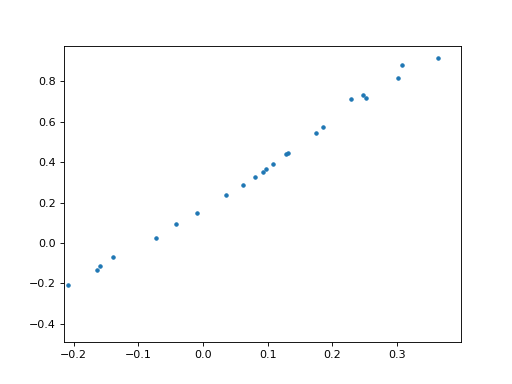

In [16]:
plt.figure()
plt.plot(m['r']-m['i'],m['g']-m['r'],'.')

In [10]:
m['g'] = m['ps1g']
del m['ps1g']
m['r'] = m['ps1r']
del m['ps1r']
m['i'] = m['ps1i']
del m['ps1i']
m['z'] = m['ps1z']
del m['ps1z']
m['y'] = m['ps1y']
del m['ps1y']

In [11]:
m

{'name': ['ckmod44852_0.0_4.00',
  'ckmod42857_0.0_4.00',
  'ckmod40862_0.0_4.00',
  'ckmod39865_0.0_4.00',
  'ckmod38867_0.0_4.00',
  'ckmod37870_0.0_4.00',
  'ckmod36872_0.0_4.00',
  'ckmod35874_0.0_4.00',
  'ckmod34877_0.0_4.00',
  'ckmod33879_0.0_4.00',
  'ckmod32882_0.0_4.00',
  'ckmod31884_0.0_4.00',
  'ckmod30000_0.0_4.00',
  'ckmod25400_0.0_4.00',
  'ckmod18700_0.0_4.00',
  'ckmod15400_0.0_4.00',
  'ckmod11900_0.0_4.00',
  'ckmod9520_0.0_4.00',
  'ckmod9230_0.0_4.00',
  'ckmod8270_0.0_4.00',
  'ckmod8200_0.0_4.50',
  'ckmod7200_0.0_4.50',
  'ckmod6890_0.0_4.50',
  'ckmod6440_0.0_4.50',
  'ckmod6200_0.0_4.50',
  'ckmod6030_0.0_4.50',
  'ckmod5860_0.0_4.50',
  'ckmod5770_0.0_4.50',
  'ckmod5570_0.0_4.50',
  'ckmod5250_0.0_4.50',
  'ckmod4780_0.0_4.50',
  'ckmod4560_0.0_4.50',
  'ckmod4350_0.0_4.50',
  'ckmod4060_0.0_4.50',
  'ckmod3850_0.0_4.50',
  'ckmod3580_0.0_4.50',
  'ckmod3500_0.0_5.00',
  'ckmod3500_0.0_5.00',
  'ckmod3500_0.0_5.00',
  'ckmod29000_0.0_3.50',
  'ckmod15000_

# DECam

In [26]:
pbnames = ['DECam.u','DECam.g','DECam.r','DECam.i','DECam.z']
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model,SVO=True)

SVO
SVO
SVO
SVO
SVO


In [31]:
files.sort()

In [32]:
files

array(['/Users/rridden/Documents/work/data/current_calspec/109vir_stis_002.dat',
       '/Users/rridden/Documents/work/data/current_calspec/10lac_stis_005.dat',
       '/Users/rridden/Documents/work/data/current_calspec/16cygb_stis_002.dat',
       '/Users/rridden/Documents/work/data/current_calspec/1732526_stisnic_005.dat',
       '/Users/rridden/Documents/work/data/current_calspec/1740346_stisnic_004.dat',
       '/Users/rridden/Documents/work/data/current_calspec/1757132_stiswfc_002.dat',
       '/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat',
       '/Users/rridden/Documents/work/data/current_calspec/1808347_stiswfc_002.dat',
       '/Users/rridden/Documents/work/data/current_calspec/18sco_stis_002.dat',
       '/Users/rridden/Documents/work/data/current_calspec/2m003618_stiswfcnic_003.dat',
       '/Users/rridden/Documents/work/data/current_calspec/agk_81d266_stisnic_007.dat',
       '/Users/rridden/Documents/work/data/current_calspec/alpha_lyr_stis_01

In [51]:
path = '/Users/rridden/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

#cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/caspec_mags_decam.npy',m)

<IPython.core.display.Javascript object>


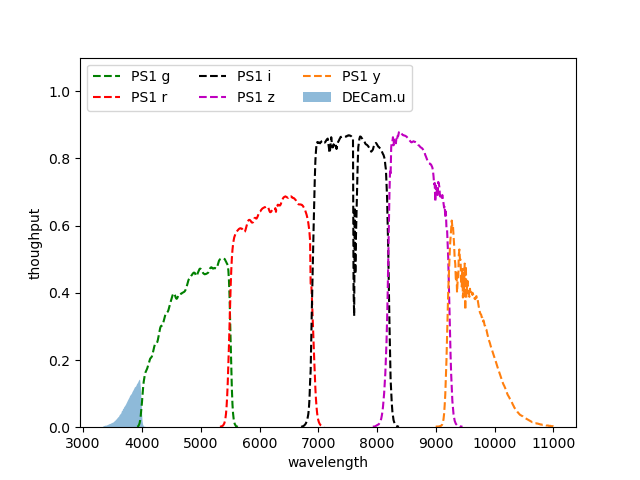

<IPython.core.display.Javascript object>


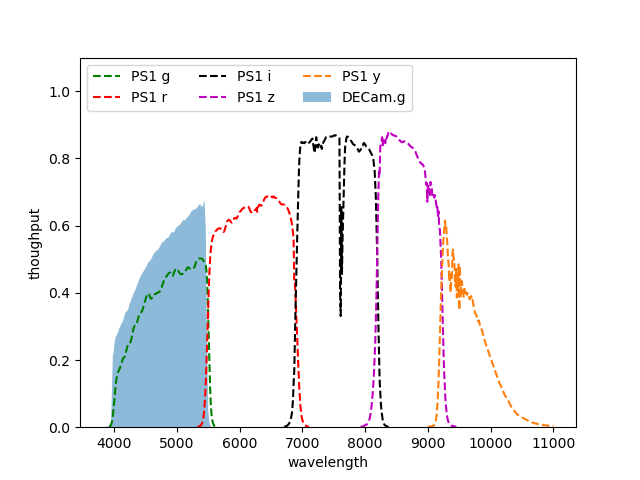

<IPython.core.display.Javascript object>


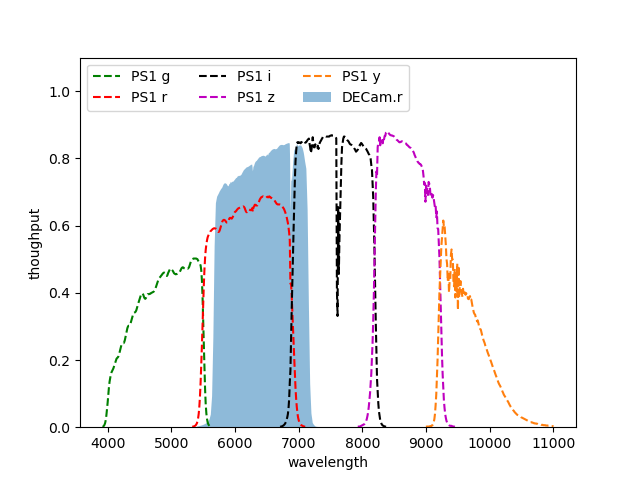

<IPython.core.display.Javascript object>


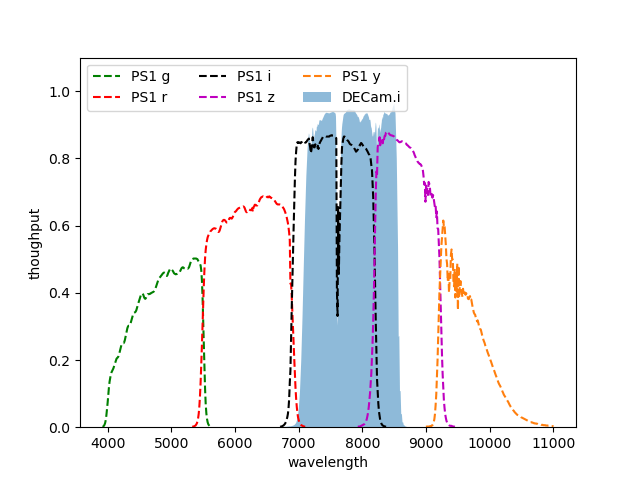

<IPython.core.display.Javascript object>


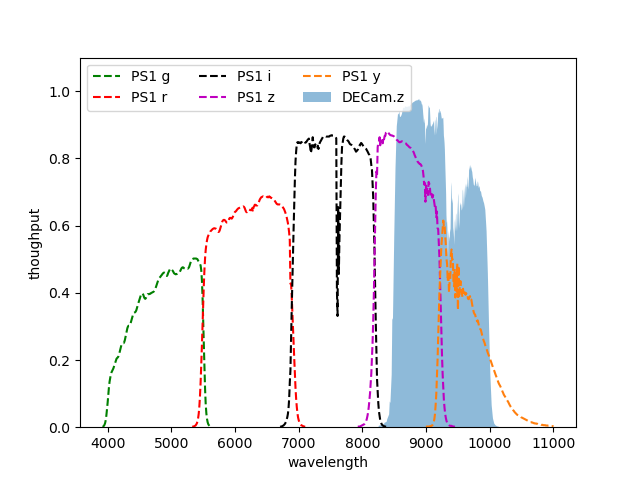

In [27]:
keys = list(pbs.keys())
for key in keys:
    plt.figure()
    plt.plot(ps1['ps1g'][0].wave,ps1['ps1g'][0].throughput,'g--',label='PS1 g')
    plt.plot(ps1['ps1r'][0].wave,ps1['ps1r'][0].throughput,'r--',label='PS1 r')
    plt.plot(ps1['ps1i'][0].wave,ps1['ps1i'][0].throughput,'k--',label='PS1 i')
    plt.plot(ps1['ps1z'][0].wave,ps1['ps1z'][0].throughput,'m--',label='PS1 z')
    plt.plot(ps1['ps1y'][0].wave,ps1['ps1y'][0].throughput,'C1--',label='PS1 y')
    #plt.plot(pbs[key][0].wave,pbs[key][0].throughput,label=key)
    plt.fill_between(pbs[key][0].wave,pbs[key][0].throughput,label=key,alpha =0.5)
    plt.legend(loc=2,ncol=3)
    plt.ylabel('thoughput')
    plt.xlabel('wavelength')
    plt.ylim(0,1.1)
    plt.savefig('figs/filter_overlap/decam/'+key+'.pdf')

# SkyMapper

In [71]:
pbnames = ['SkyMapper.u','SkyMapper.v','SkyMapper.g','SkyMapper.r','SkyMapper.i','SkyMapper.z']
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model,SVO=True)

SVO
SVO
SVO
SVO
SVO
SVO


In [13]:
from scipy.interpolate import interp1d

In [30]:
w = pbs['SkyMapper.z'][0].wave
t = pbs['SkyMapper.z'][0].throughput
wave = np.arange(w[0],w[-1],10)
interp = interp1d(w,t)
through = interp(wave)
band = np.array([wave.astype(int),through]).T
band
np.savetxt('SM_z.txt',band, fmt='%3f')

<IPython.core.display.Javascript object>


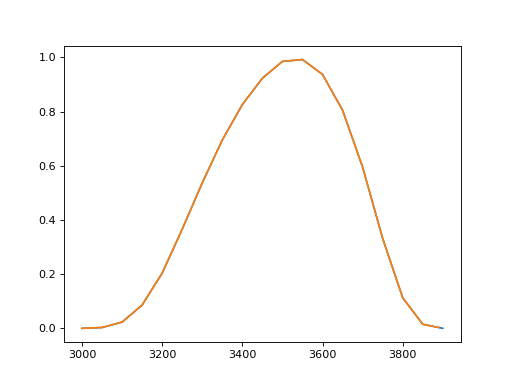

In [25]:
plt.figure()
plt.plot(pbs['SkyMapper.u'][0].wave,pbs['SkyMapper.u'][0].throughput)
plt.plot(wave,through)

In [56]:
path = '/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/'
files = glob(path+'*.dat')
files = np.array(files)
files.sort()
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
#files = files[ind]

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/calspec_mags_skymapper.npy',m)

/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/109vir_stis_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/10lac_stis_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/16cygb_stis_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1732526_stisnic_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1740346_stisnic_004.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1757132_stiswfc_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1805292_stisnic_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1808347_stiswfc_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/18sco_stis_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/2m003618_stiswfcnic_003.dat
/Users/rridden/Documents/work/code

/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd0947_857_stis_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1026_453_stis_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1057_719_stisnic_008.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1327_083_stiswfc_003.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1657_343_stiswfcnic_003.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd2341_322_stiswfc_003.dat


In [50]:
test = {'u':m['SkyMapper.u'],'v':m['SkyMapper.v'],'g':m['SkyMapper.g'],'r':m['SkyMapper.r']
       ,'i':m['SkyMapper.i'],'z':m['SkyMapper.z'],'name':m['name']}

In [57]:
test = {'g':m['SkyMapper.g'],'r':m['SkyMapper.r']
       ,'i':m['SkyMapper.i'],'z':m['SkyMapper.z'],'name':m['name']}

In [58]:
np.save('cal_mags/calspec_ab_mags_skymapper.npy',test)

In [72]:
# use this one!!
files = glob('ck_spec_files/*.dat')
files = np.array(files)
files.sort()

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['u'] = m['SkyMapper.u']
del m['SkyMapper.u']
m['v'] = m['SkyMapper.v']
del m['SkyMapper.v']
m['g'] = m['SkyMapper.g']
del m['SkyMapper.g']
m['r'] = m['SkyMapper.r']
del m['SkyMapper.r']
m['i'] = m['SkyMapper.i']
del m['SkyMapper.i']
m['z'] = m['SkyMapper.z']
del m['SkyMapper.z']
m['name'] = names
np.save('cal_mags/ckmodel_ab_mags_skymapper.npy',m)

ck_spec_files/ckmod11900_0.0_4.00.dat
ck_spec_files/ckmod13600_0.0_2.50.dat
ck_spec_files/ckmod15000_0.0_3.50.dat
ck_spec_files/ckmod15400_0.0_4.00.dat
ck_spec_files/ckmod18700_0.0_4.00.dat
ck_spec_files/ckmod25400_0.0_4.00.dat
ck_spec_files/ckmod26000_0.0_3.00.dat
ck_spec_files/ckmod29000_0.0_3.50.dat
ck_spec_files/ckmod30000_0.0_4.00.dat
ck_spec_files/ckmod31884_0.0_4.00.dat
ck_spec_files/ckmod32882_0.0_4.00.dat
ck_spec_files/ckmod33879_0.0_4.00.dat
ck_spec_files/ckmod34877_0.0_4.00.dat
ck_spec_files/ckmod3500_0.0_5.00.dat
ck_spec_files/ckmod3580_0.0_4.50.dat
ck_spec_files/ckmod35874_0.0_4.00.dat
ck_spec_files/ckmod36872_0.0_4.00.dat
ck_spec_files/ckmod37870_0.0_4.00.dat
ck_spec_files/ckmod3800_0.0_1.50.dat
ck_spec_files/ckmod3850_0.0_4.50.dat
ck_spec_files/ckmod38867_0.0_4.00.dat
ck_spec_files/ckmod3950_0.0_1.50.dat
ck_spec_files/ckmod4060_0.0_4.50.dat
ck_spec_files/ckmod4350_0.0_4.50.dat
ck_spec_files/ckmod4420_0.0_1.00.dat
ck_spec_files/ckmod4560_0.0_4.50.dat
ck_spec_files/ckmod47

In [20]:
pbnames = pbs.keys()

models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
names = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
        names += [modstring]
model_sed = source_synphot.source.load_source(model_sed_names)


curmag = Spec_mags(model_sed,pbs)
m = deepcopy(curmag)
m['u'] = m['SkyMapper.u']
del m['SkyMapper.u']
m['v'] = m['SkyMapper.v']
del m['SkyMapper.v']
m['g'] = m['SkyMapper.g']
del m['SkyMapper.g']
m['r'] = m['SkyMapper.r']
del m['SkyMapper.r']
m['i'] = m['SkyMapper.i']
del m['SkyMapper.i']
m['z'] = m['SkyMapper.z']
del m['SkyMapper.z']
m['name'] = names
np.save('cal_mags/ckmodel_ab_mags_skymapper.npy',m)

In [48]:
model_sed['ckmod44852_0.0_4.00']

KeyError: 'ckmod44852_0.0_4.00'

In [62]:
from astropy.table import Table

In [63]:
names = list(model_sed.keys())
for name in names:
    s = model_sed[name]
    f = s.flux 
    w = s.wave
    t = Table(names=['wave','flux'],data=[w,f])
    t.write('ck_spec_files/'+name +'.dat',format='ascii')

In [64]:
files = glob('ck_spec_files/*.dat')
files = np.array(files)
files.sort()

In [67]:
files

array(['ck_spec_files/ckmod11900_0.0_4.00.dat',
       'ck_spec_files/ckmod13600_0.0_2.50.dat',
       'ck_spec_files/ckmod15000_0.0_3.50.dat',
       'ck_spec_files/ckmod15400_0.0_4.00.dat',
       'ck_spec_files/ckmod18700_0.0_4.00.dat',
       'ck_spec_files/ckmod25400_0.0_4.00.dat',
       'ck_spec_files/ckmod26000_0.0_3.00.dat',
       'ck_spec_files/ckmod29000_0.0_3.50.dat',
       'ck_spec_files/ckmod30000_0.0_4.00.dat',
       'ck_spec_files/ckmod31884_0.0_4.00.dat',
       'ck_spec_files/ckmod32882_0.0_4.00.dat',
       'ck_spec_files/ckmod33879_0.0_4.00.dat',
       'ck_spec_files/ckmod34877_0.0_4.00.dat',
       'ck_spec_files/ckmod3500_0.0_5.00.dat',
       'ck_spec_files/ckmod3580_0.0_4.50.dat',
       'ck_spec_files/ckmod35874_0.0_4.00.dat',
       'ck_spec_files/ckmod36872_0.0_4.00.dat',
       'ck_spec_files/ckmod37870_0.0_4.00.dat',
       'ck_spec_files/ckmod3800_0.0_1.50.dat',
       'ck_spec_files/ckmod3850_0.0_4.50.dat',
       'ck_spec_files/ckmod38867_0.0_4.00.da

In [69]:
m['name']

['ckmod44852_0.0_4.00',
 'ckmod42857_0.0_4.00',
 'ckmod40862_0.0_4.00',
 'ckmod39865_0.0_4.00',
 'ckmod38867_0.0_4.00',
 'ckmod37870_0.0_4.00',
 'ckmod36872_0.0_4.00',
 'ckmod35874_0.0_4.00',
 'ckmod34877_0.0_4.00',
 'ckmod33879_0.0_4.00',
 'ckmod32882_0.0_4.00',
 'ckmod31884_0.0_4.00',
 'ckmod30000_0.0_4.00',
 'ckmod25400_0.0_4.00',
 'ckmod18700_0.0_4.00',
 'ckmod15400_0.0_4.00',
 'ckmod11900_0.0_4.00',
 'ckmod9520_0.0_4.00',
 'ckmod9230_0.0_4.00',
 'ckmod8270_0.0_4.00',
 'ckmod8200_0.0_4.50',
 'ckmod7200_0.0_4.50',
 'ckmod6890_0.0_4.50',
 'ckmod6440_0.0_4.50',
 'ckmod6200_0.0_4.50',
 'ckmod6030_0.0_4.50',
 'ckmod5860_0.0_4.50',
 'ckmod5770_0.0_4.50',
 'ckmod5570_0.0_4.50',
 'ckmod5250_0.0_4.50',
 'ckmod4780_0.0_4.50',
 'ckmod4560_0.0_4.50',
 'ckmod4350_0.0_4.50',
 'ckmod4060_0.0_4.50',
 'ckmod3850_0.0_4.50',
 'ckmod3580_0.0_4.50',
 'ckmod3500_0.0_5.00',
 'ckmod3500_0.0_5.00',
 'ckmod3500_0.0_5.00',
 'ckmod29000_0.0_3.50',
 'ckmod15000_0.0_3.50',
 'ckmod5850_0.0_3.00',
 'ckmod5150_0.0

In [61]:
!open ck_spec_files

In [37]:
w.astype(object)

array([90.9000015258789, 93.5, 96.0999984741211, ..., 1200000.0,
       1400000.0, 1600000.0], dtype=object)

###### from copy import deepcopy

In [37]:
test = dee

new_keys = ['u','v','g','r','i','z','name']

for key,n_key in zip(m.keys(), new_keys):
    m[n_key] = m.pop(key)

RuntimeError: dictionary changed size during iteration

# Gaia

In [7]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("GAIA")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)

In [8]:
pbs

OrderedDict([('gaiag',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f8a51c78c90>,
               -21.375993149393477)),
             ('gaiab',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f8a395a6890>,
               -20.94986479118612)),
             ('gaiar',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f8a395b9c90>,
               -21.859714513454705))])

In [13]:
from scipy.interpolate import interp1d

In [13]:
path = '/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/'
files = glob(path+'*.dat')
files = np.array(files)
files.sort()
#files = np.array(glob(path+'*.fits'))

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/calspec_mags_gaia.npy',m)

/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/109vir_stis_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/10lac_stis_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/16cygb_stis_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1732526_stisnic_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1740346_stisnic_004.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1757132_stiswfc_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1805292_stisnic_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/1808347_stiswfc_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/18sco_stis_002.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/2m003618_stiswfcnic_003.dat
/Users/rridden/Documents/work/code

/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd0947_857_stis_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1026_453_stis_005.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1057_719_stisnic_008.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1327_083_stiswfc_003.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd1657_343_stiswfcnic_003.dat
/Users/rridden/Documents/work/code/calibrimbore/calibrimbore/data/calspec/wd2341_322_stiswfc_003.dat


# MOA

In [5]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("MOA")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)

path = '/Users/rridden/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files.sort()
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/caspec_mags_moa.npy',m)

/Users/rridden/Documents/work/data/current_calspec/hs2027_stis_005.dat
Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd_75d325_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/sdss132811_stis_003.dat
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/ngc6681_4_stis_001.dat
Warning, 26 of 2771 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Do

/Users/rridden/Documents/work/data/current_calspec/1808347_stiswfc_002.dat
Warning, 94 of 6875 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd55677_stis_002.dat
Warning, 12 of 7207 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/109vir_stis_002.dat
/Users/rridden/Documents/work/data/current_calspec/ngc6681_7_stis_001.dat
Warning, 919 of 2788 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd106252_stis_005.dat
Warning, 29 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd37725_stiswfc_002.dat
Warning, 57 of 7167 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd93521_stis_006.dat
/Users/rridden/Documents/work/data/current_calspec/kf06t2_stiswfcnic_002.dat
Warning, 1

In [17]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)


curmag = Spec_mags(model_sed,pbs)
m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/ckmodel_mags_skymapper.npy',m)

In [19]:
model_sed

OrderedDict([('ckmod38867_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98fa253090>),
             ('ckmod37870_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f983b56fe50>),
             ('ckmod36872_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f9825ed9c50>),
             ('ckmod35874_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f983b56ff90>),
             ('ckmod34877_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98fa24a5d0>),
             ('ckmod33879_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98fa20ca90>),
             ('ckmod32882_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f989aa3fa90>),
             ('ckmod31884_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98a8bcf5d0>),
             ('ckmod30000_0.0_4.00',
              <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98b98a

<IPython.core.display.Javascript object>


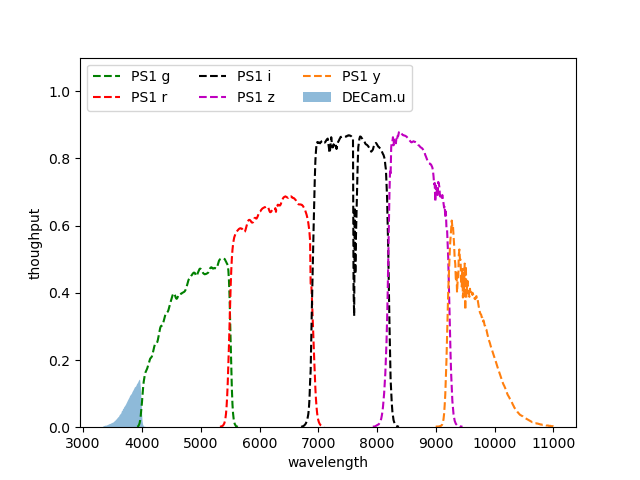

<IPython.core.display.Javascript object>


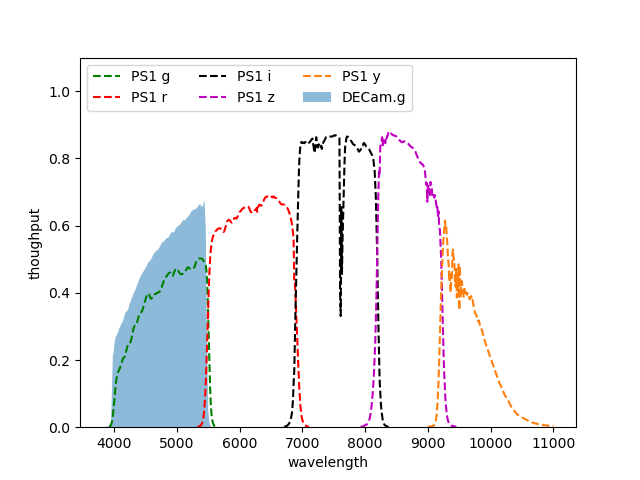

<IPython.core.display.Javascript object>


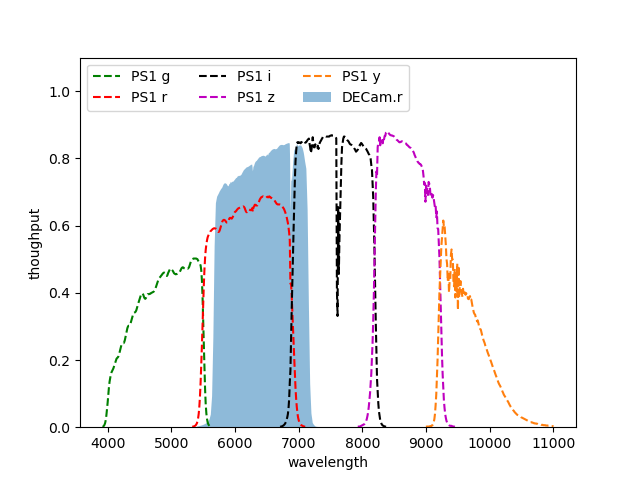

<IPython.core.display.Javascript object>


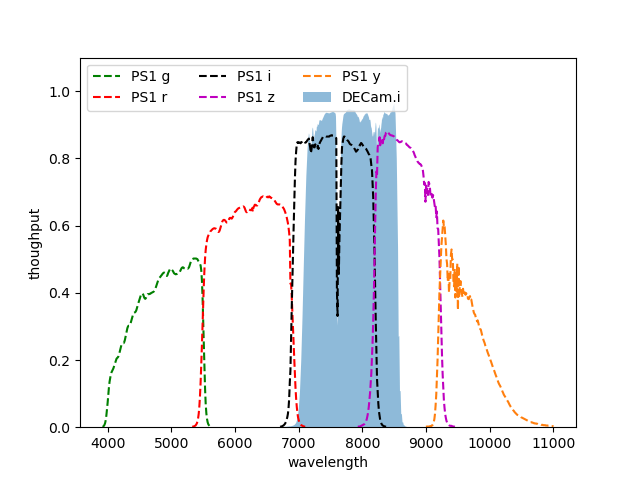

<IPython.core.display.Javascript object>


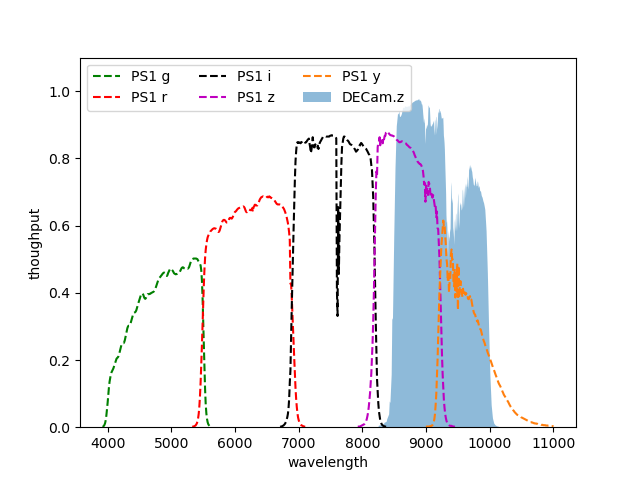

In [27]:
keys = list(pbs.keys())
for key in keys:
    plt.figure()
    plt.plot(ps1['ps1g'][0].wave,ps1['ps1g'][0].throughput,'g--',label='PS1 g')
    plt.plot(ps1['ps1r'][0].wave,ps1['ps1r'][0].throughput,'r--',label='PS1 r')
    plt.plot(ps1['ps1i'][0].wave,ps1['ps1i'][0].throughput,'k--',label='PS1 i')
    plt.plot(ps1['ps1z'][0].wave,ps1['ps1z'][0].throughput,'m--',label='PS1 z')
    plt.plot(ps1['ps1y'][0].wave,ps1['ps1y'][0].throughput,'C1--',label='PS1 y')
    #plt.plot(pbs[key][0].wave,pbs[key][0].throughput,label=key)
    plt.fill_between(pbs[key][0].wave,pbs[key][0].throughput,label=key,alpha =0.5)
    plt.legend(loc=2,ncol=3)
    plt.ylabel('thoughput')
    plt.xlabel('wavelength')
    plt.ylim(0,1.1)
    plt.savefig('figs/filter_overlap/decam/'+key+'.pdf')

# KeplerCam

In [5]:
pbnames = ['KeplerCam.u','KeplerCam.g','KeplerCam.r','KeplerCam.i','KeplerCam.z',
           'KeplerCam.B_Harris','KeplerCam.V_Harris','KeplerCam.R_Harris','KeplerCam.I_Harris','KeplerCam.Z_Harris']
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model,SVO=True)

SVO
SVO
SVO
SVO
SVO
SVO
SVO
SVO
SVO
SVO


In [8]:
path = '/Users/rridden/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/caspec_mags_keplercam.npy',m)

/Users/rridden/Documents/work/data/current_calspec/hs2027_stis_005.dat
Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd_75d325_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/sdss132811_stis_003.dat
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/ngc6681_4_stis_001.dat
Warning, 26 of 2771 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Do

/Users/rridden/Documents/work/data/current_calspec/1808347_stiswfc_002.dat
Warning, 94 of 6875 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd55677_stis_002.dat
Warning, 12 of 7207 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/109vir_stis_002.dat
/Users/rridden/Documents/work/data/current_calspec/ngc6681_7_stis_001.dat
Warning, 919 of 2788 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd106252_stis_005.dat
Warning, 29 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd37725_stiswfc_002.dat
Warning, 57 of 7167 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd93521_stis_006.dat
/Users/rridden/Documents/work/data/current_calspec/kf06t2_stiswfcnic_002.dat
Warning, 1

# KeplerCam 2 

In [21]:
a = pbs['B_kepcam'][0]
b = pbs['r_kepcam'][0]

In [23]:
from scipy.interpolate import interp1d

In [29]:
a = pbs['B_kepcam'][0]
b = pbs['r_kepcam'][0]
c = interp1d(b.wave,b.throughput,bounds_error=False,fill_value=0)
np.nansum(c(a.wave) * a.throughput)


0.066943

In [11]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
#pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
#pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("keplercam")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)

In [12]:
path = '/Users/rridden/Documents/work/data/current_calspec/'
files = glob(path+'*.dat')
files = np.array(files)
#files = np.array(glob(path+'*.fits'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

cur = Specs(files)
curmag = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(curmag)
m['name'] = names
np.save('cal_mags/caspec_mags_keplercam.npy',m)

/Users/rridden/Documents/work/data/current_calspec/hs2027_stis_005.dat
Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd_75d325_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/sdss132811_stis_003.dat
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/ngc6681_4_stis_001.dat
Warning, 26 of 2771 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Do

/Users/rridden/Documents/work/data/current_calspec/1808347_stiswfc_002.dat
Warning, 94 of 6875 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd55677_stis_002.dat
Warning, 12 of 7207 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/109vir_stis_002.dat
/Users/rridden/Documents/work/data/current_calspec/ngc6681_7_stis_001.dat
Warning, 919 of 2788 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd106252_stis_005.dat
Warning, 29 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd37725_stiswfc_002.dat
Warning, 57 of 7167 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd93521_stis_006.dat
/Users/rridden/Documents/work/data/current_calspec/kf06t2_stiswfcnic_002.dat
Warning, 1

In [13]:
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
ps1 = source_synphot.passband.load_pbs(pbnames, model_mags, model)

<IPython.core.display.Javascript object>


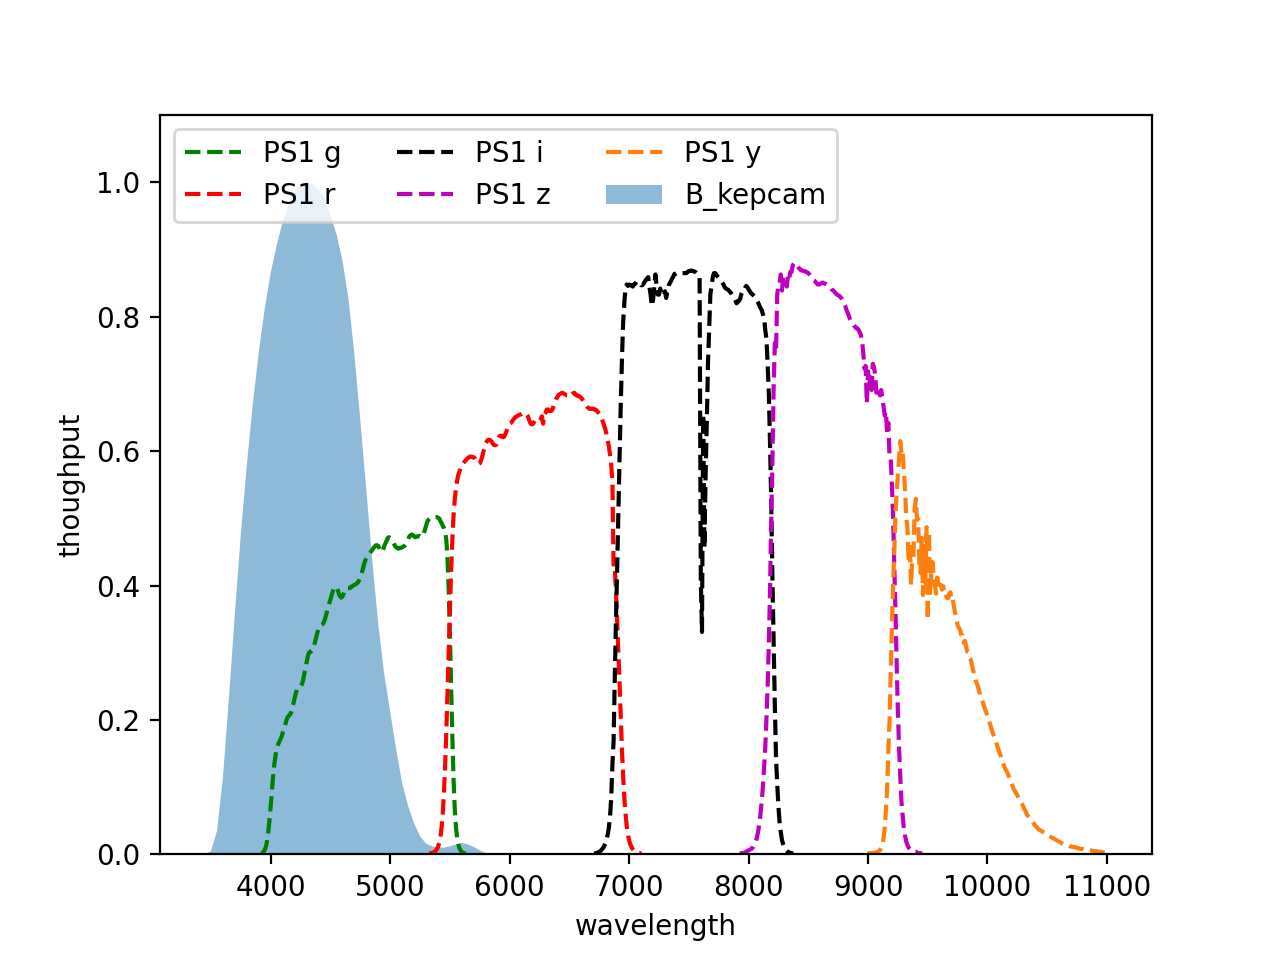

<IPython.core.display.Javascript object>


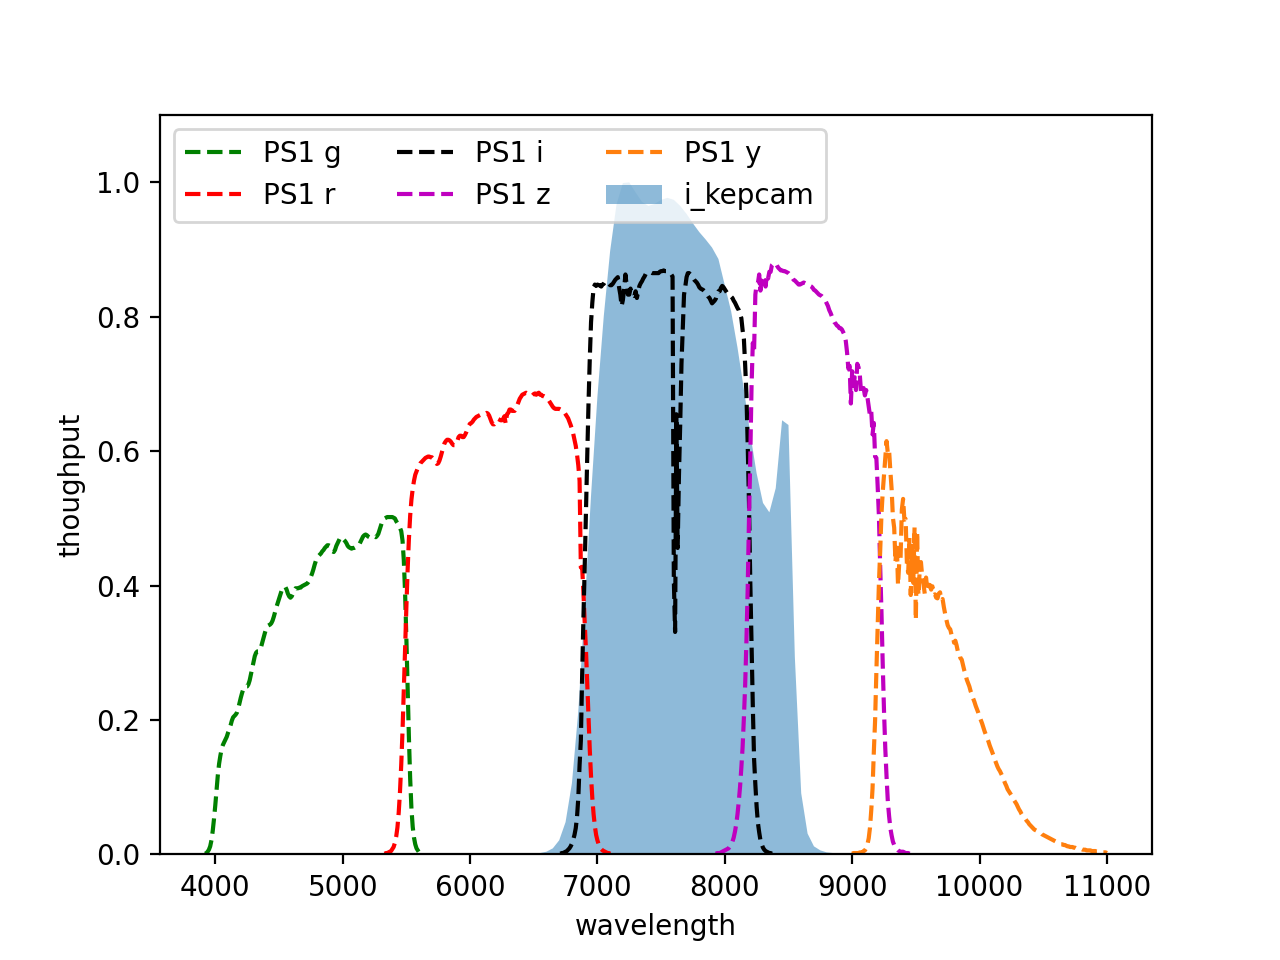

<IPython.core.display.Javascript object>


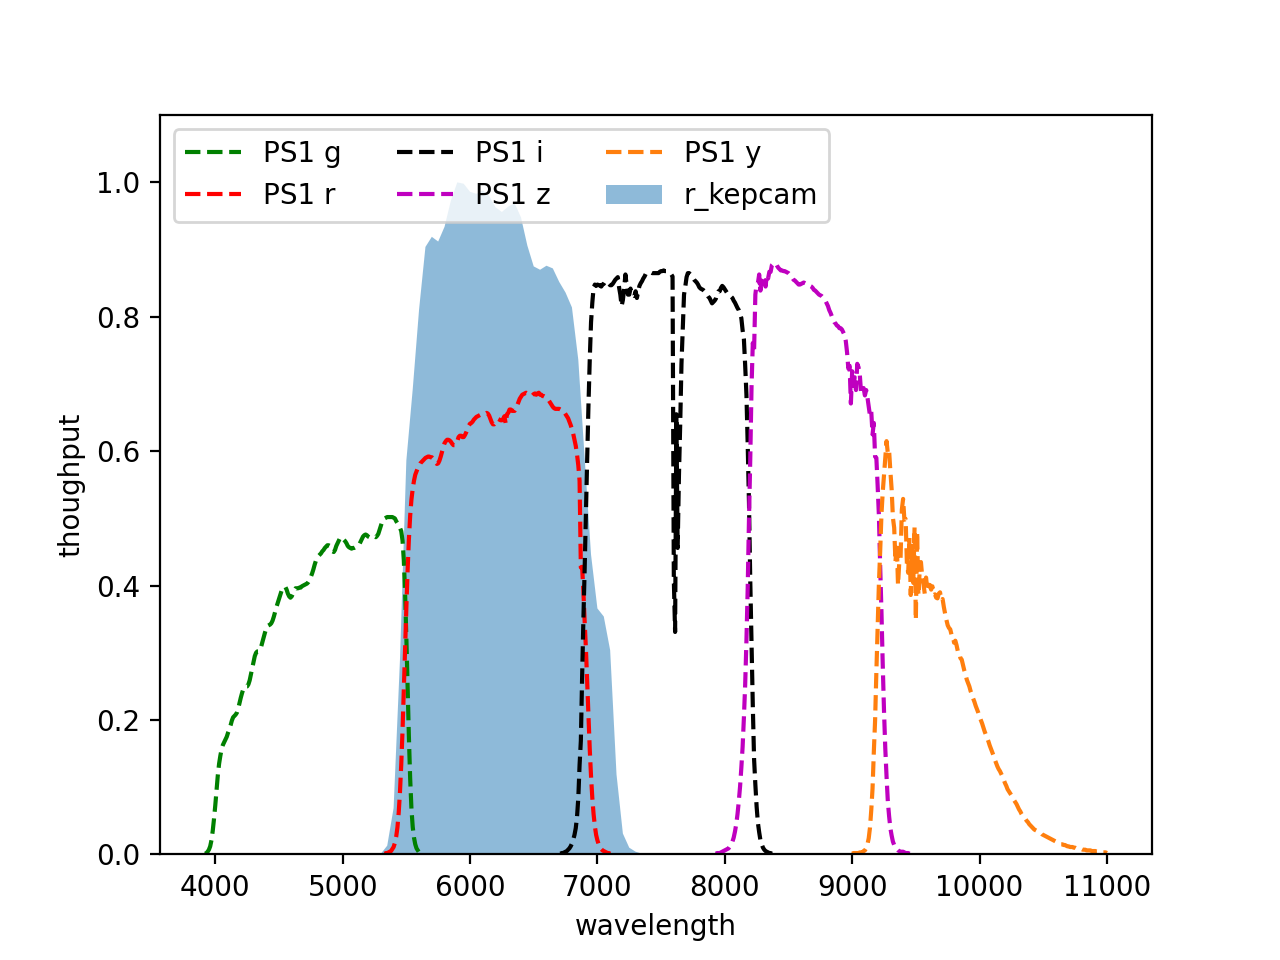

<IPython.core.display.Javascript object>


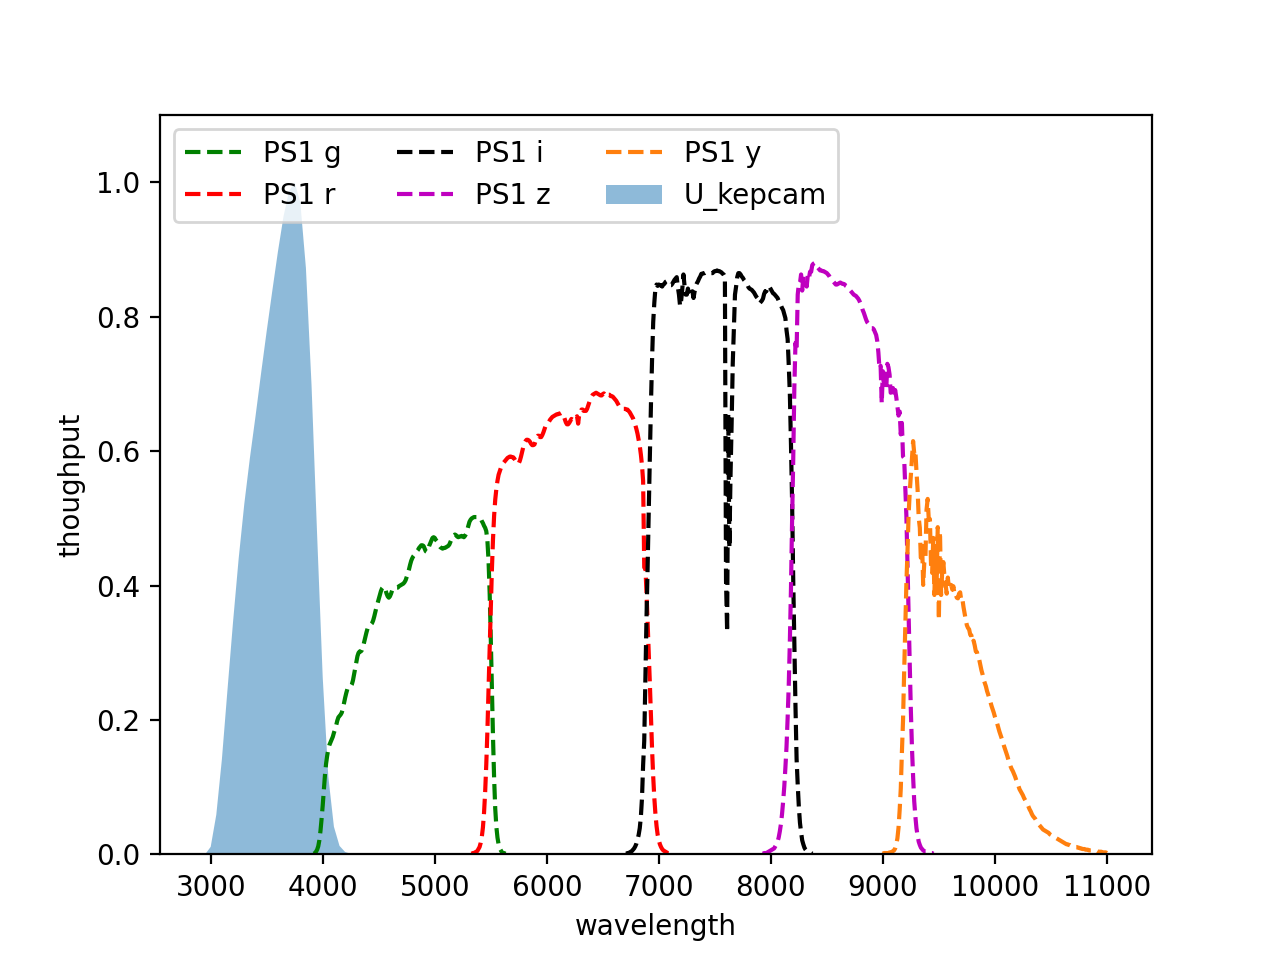

<IPython.core.display.Javascript object>


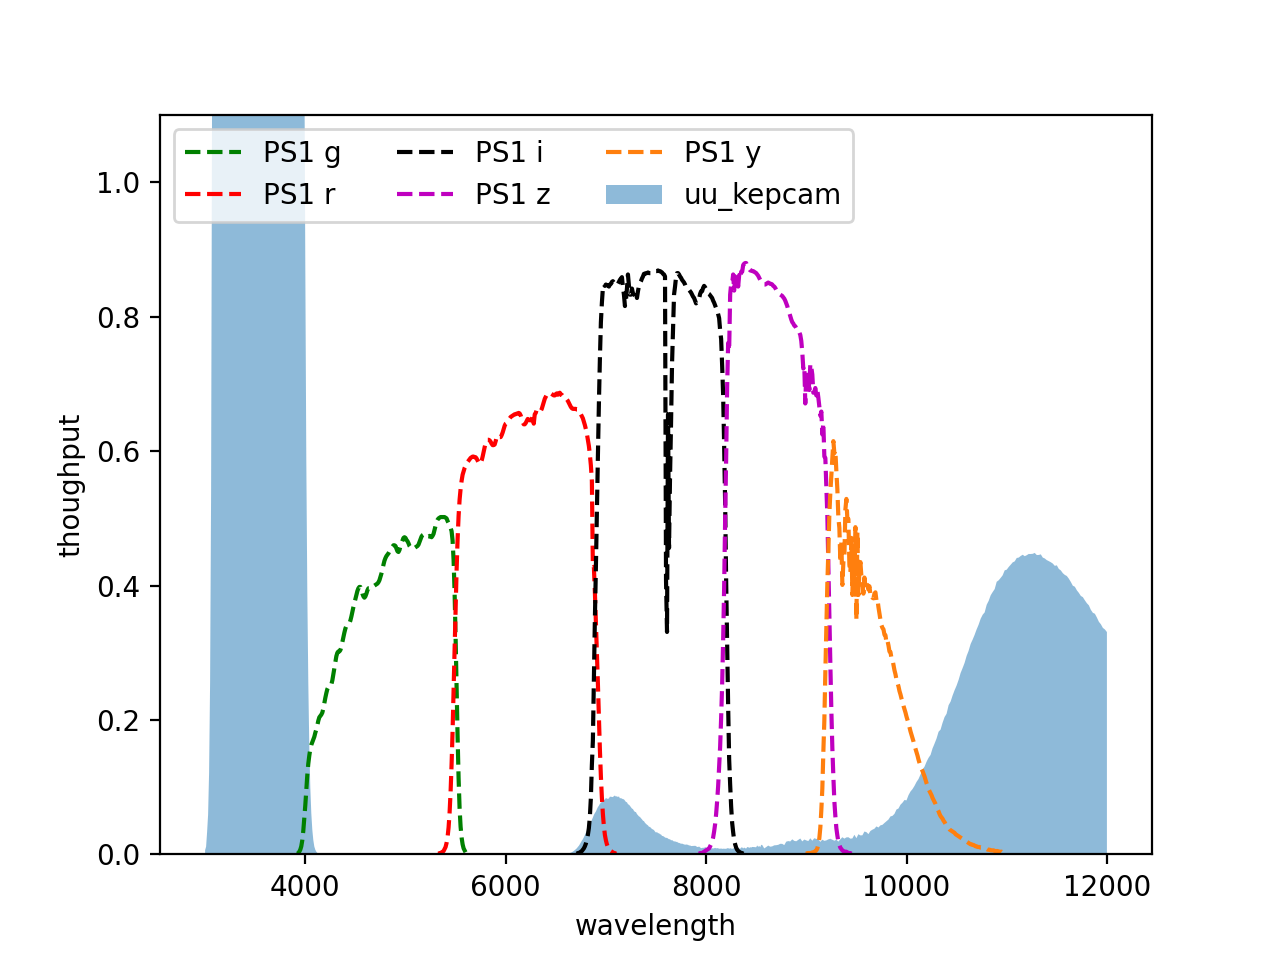

<IPython.core.display.Javascript object>


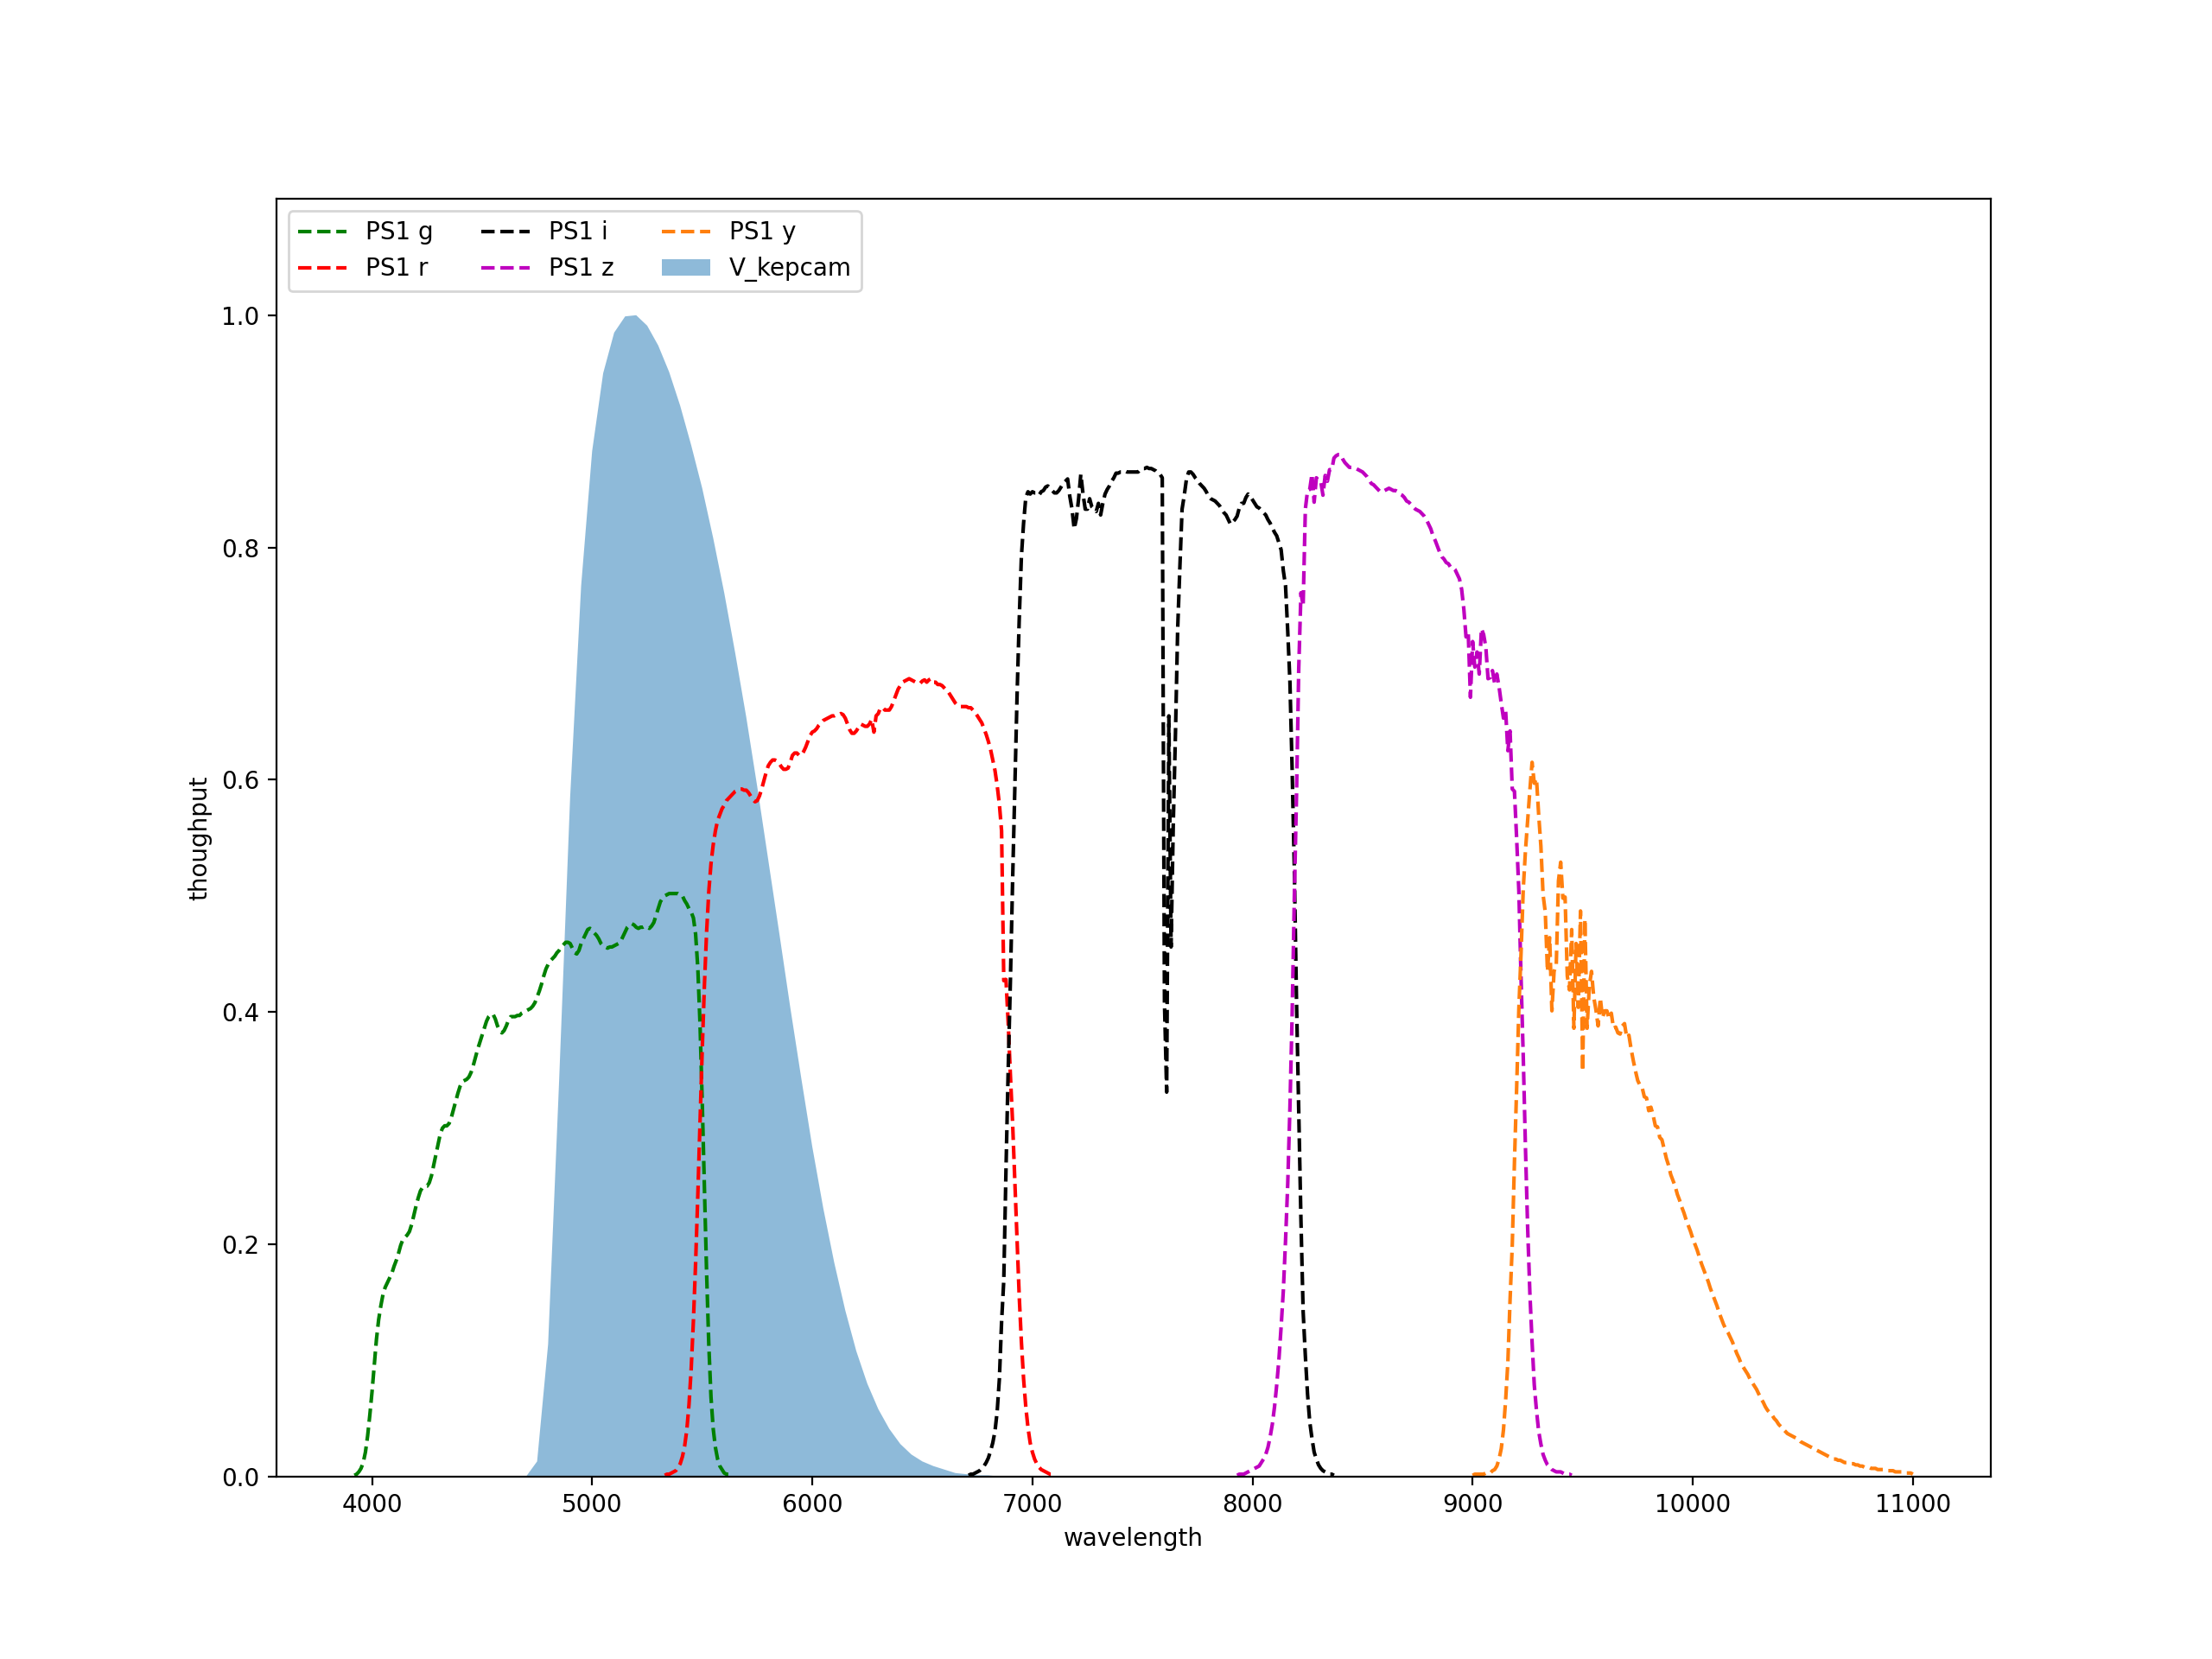

<IPython.core.display.Javascript object>


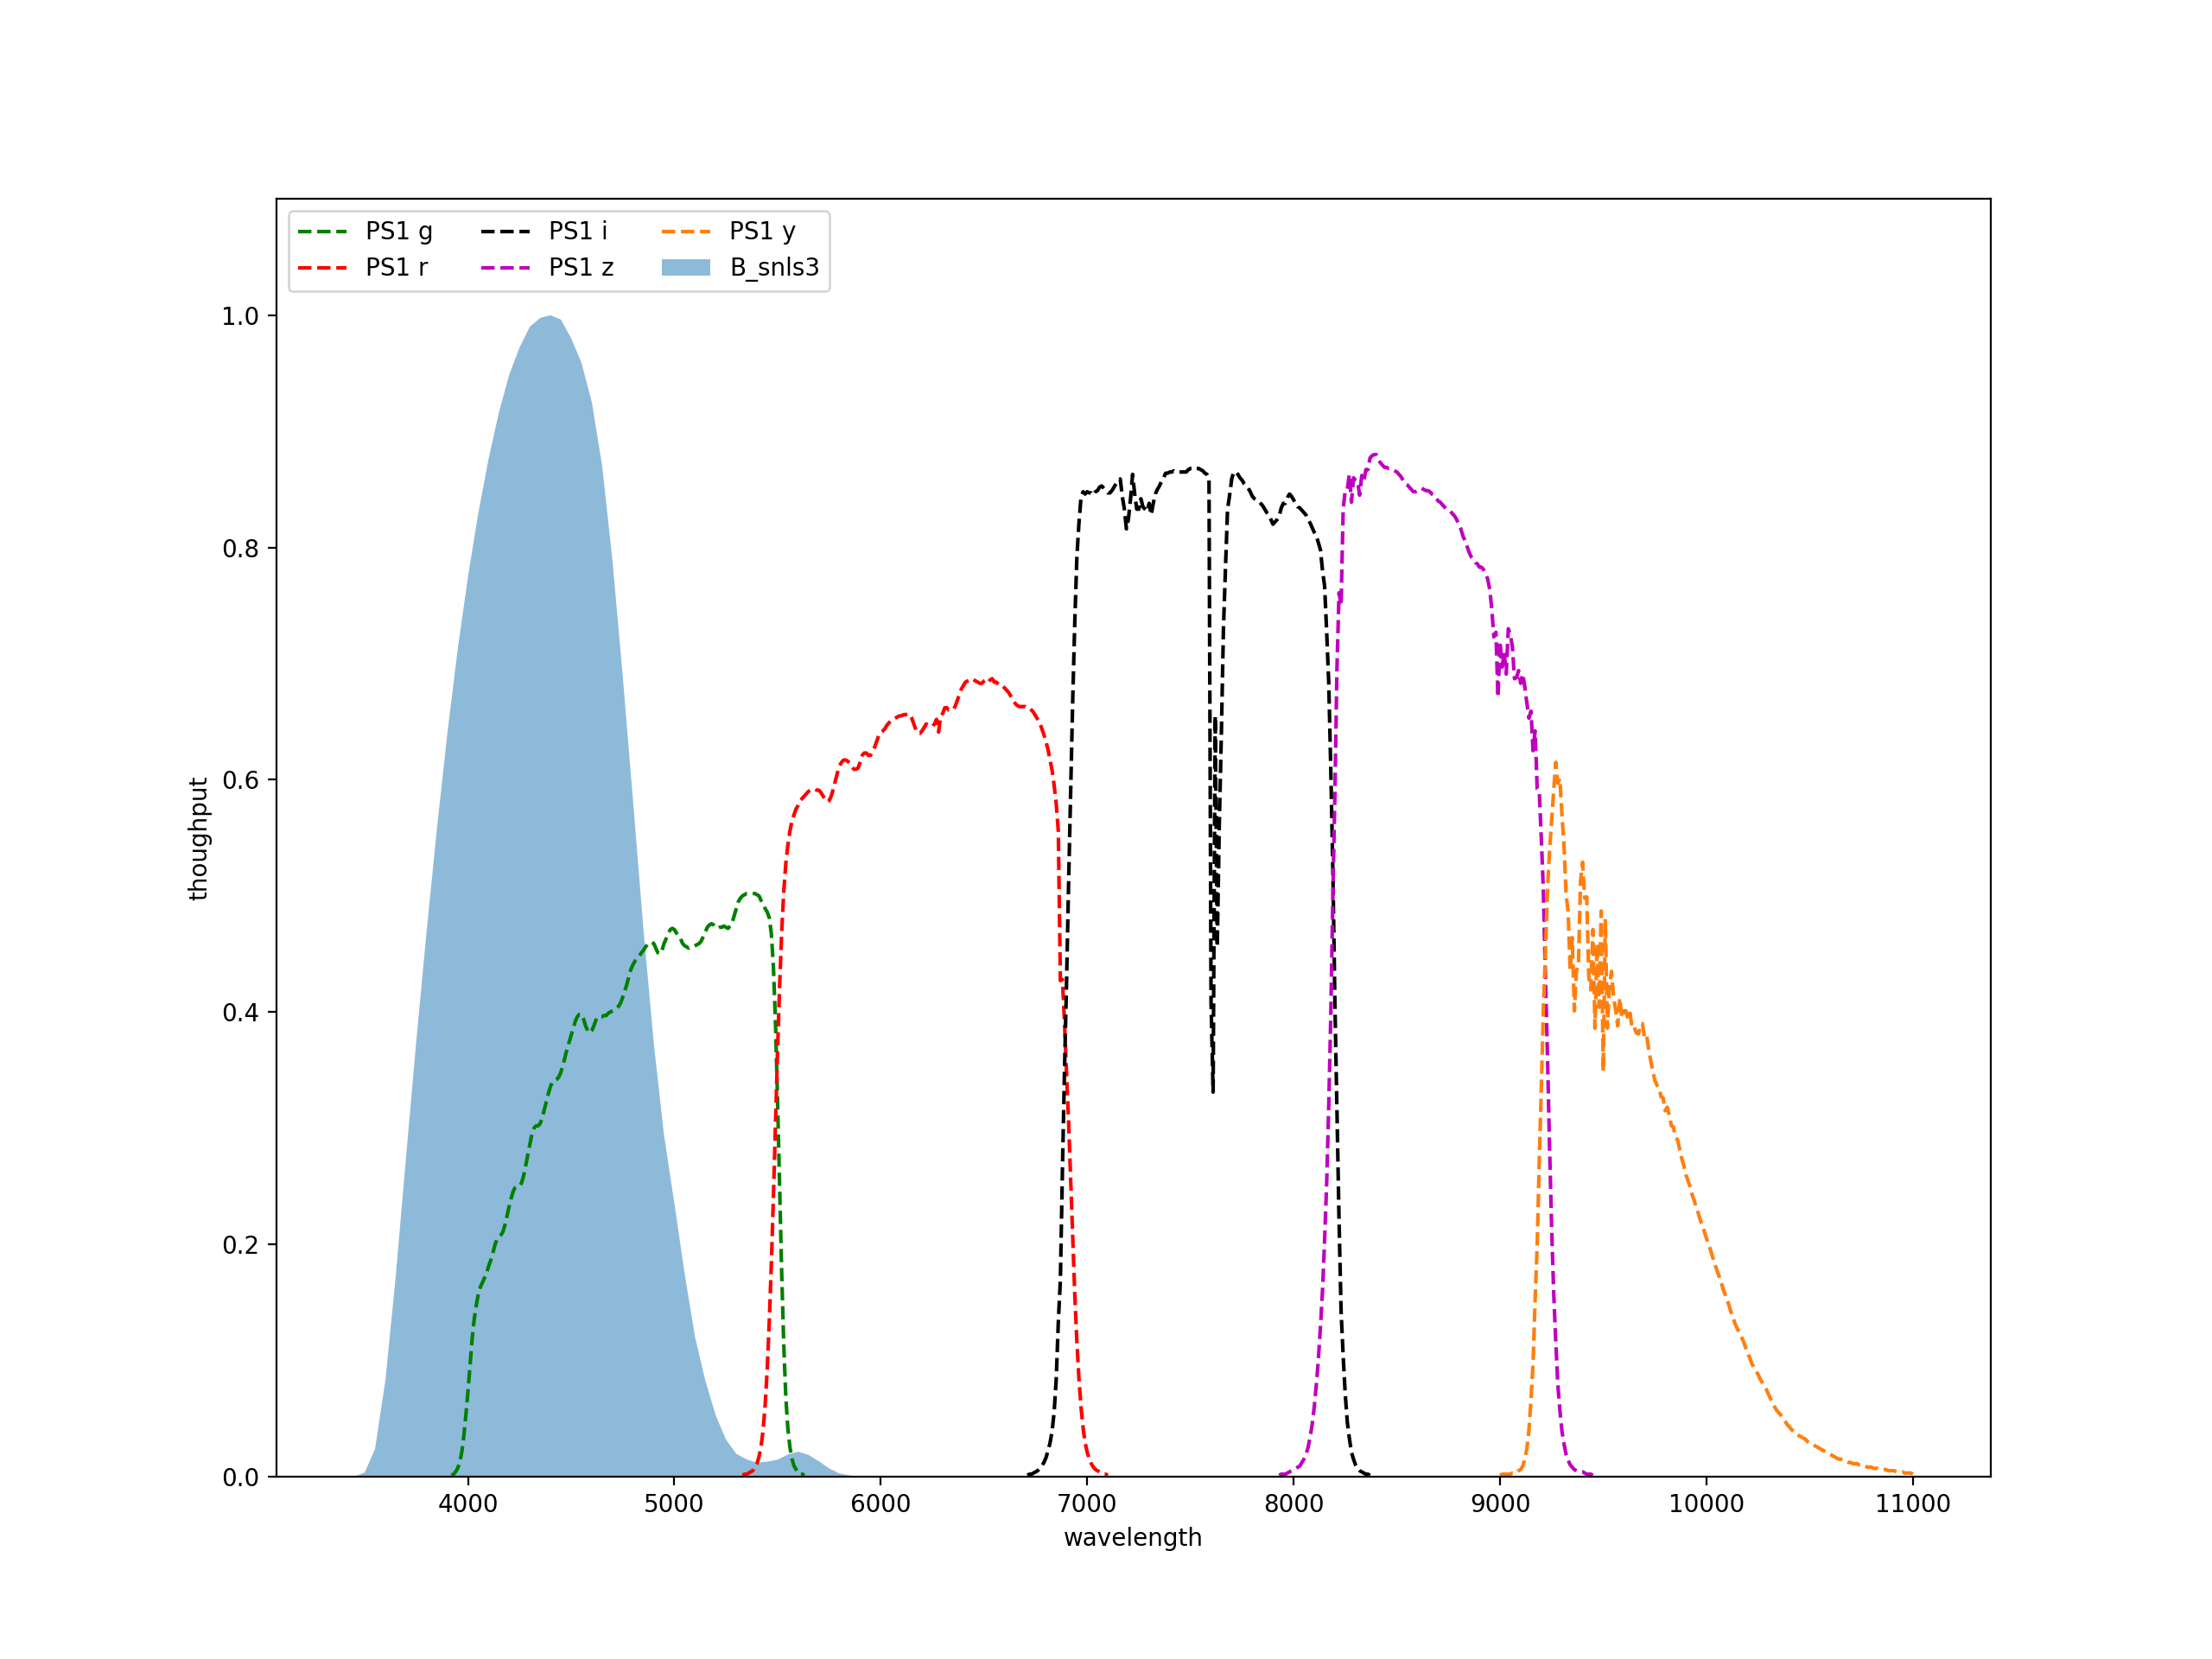

<IPython.core.display.Javascript object>


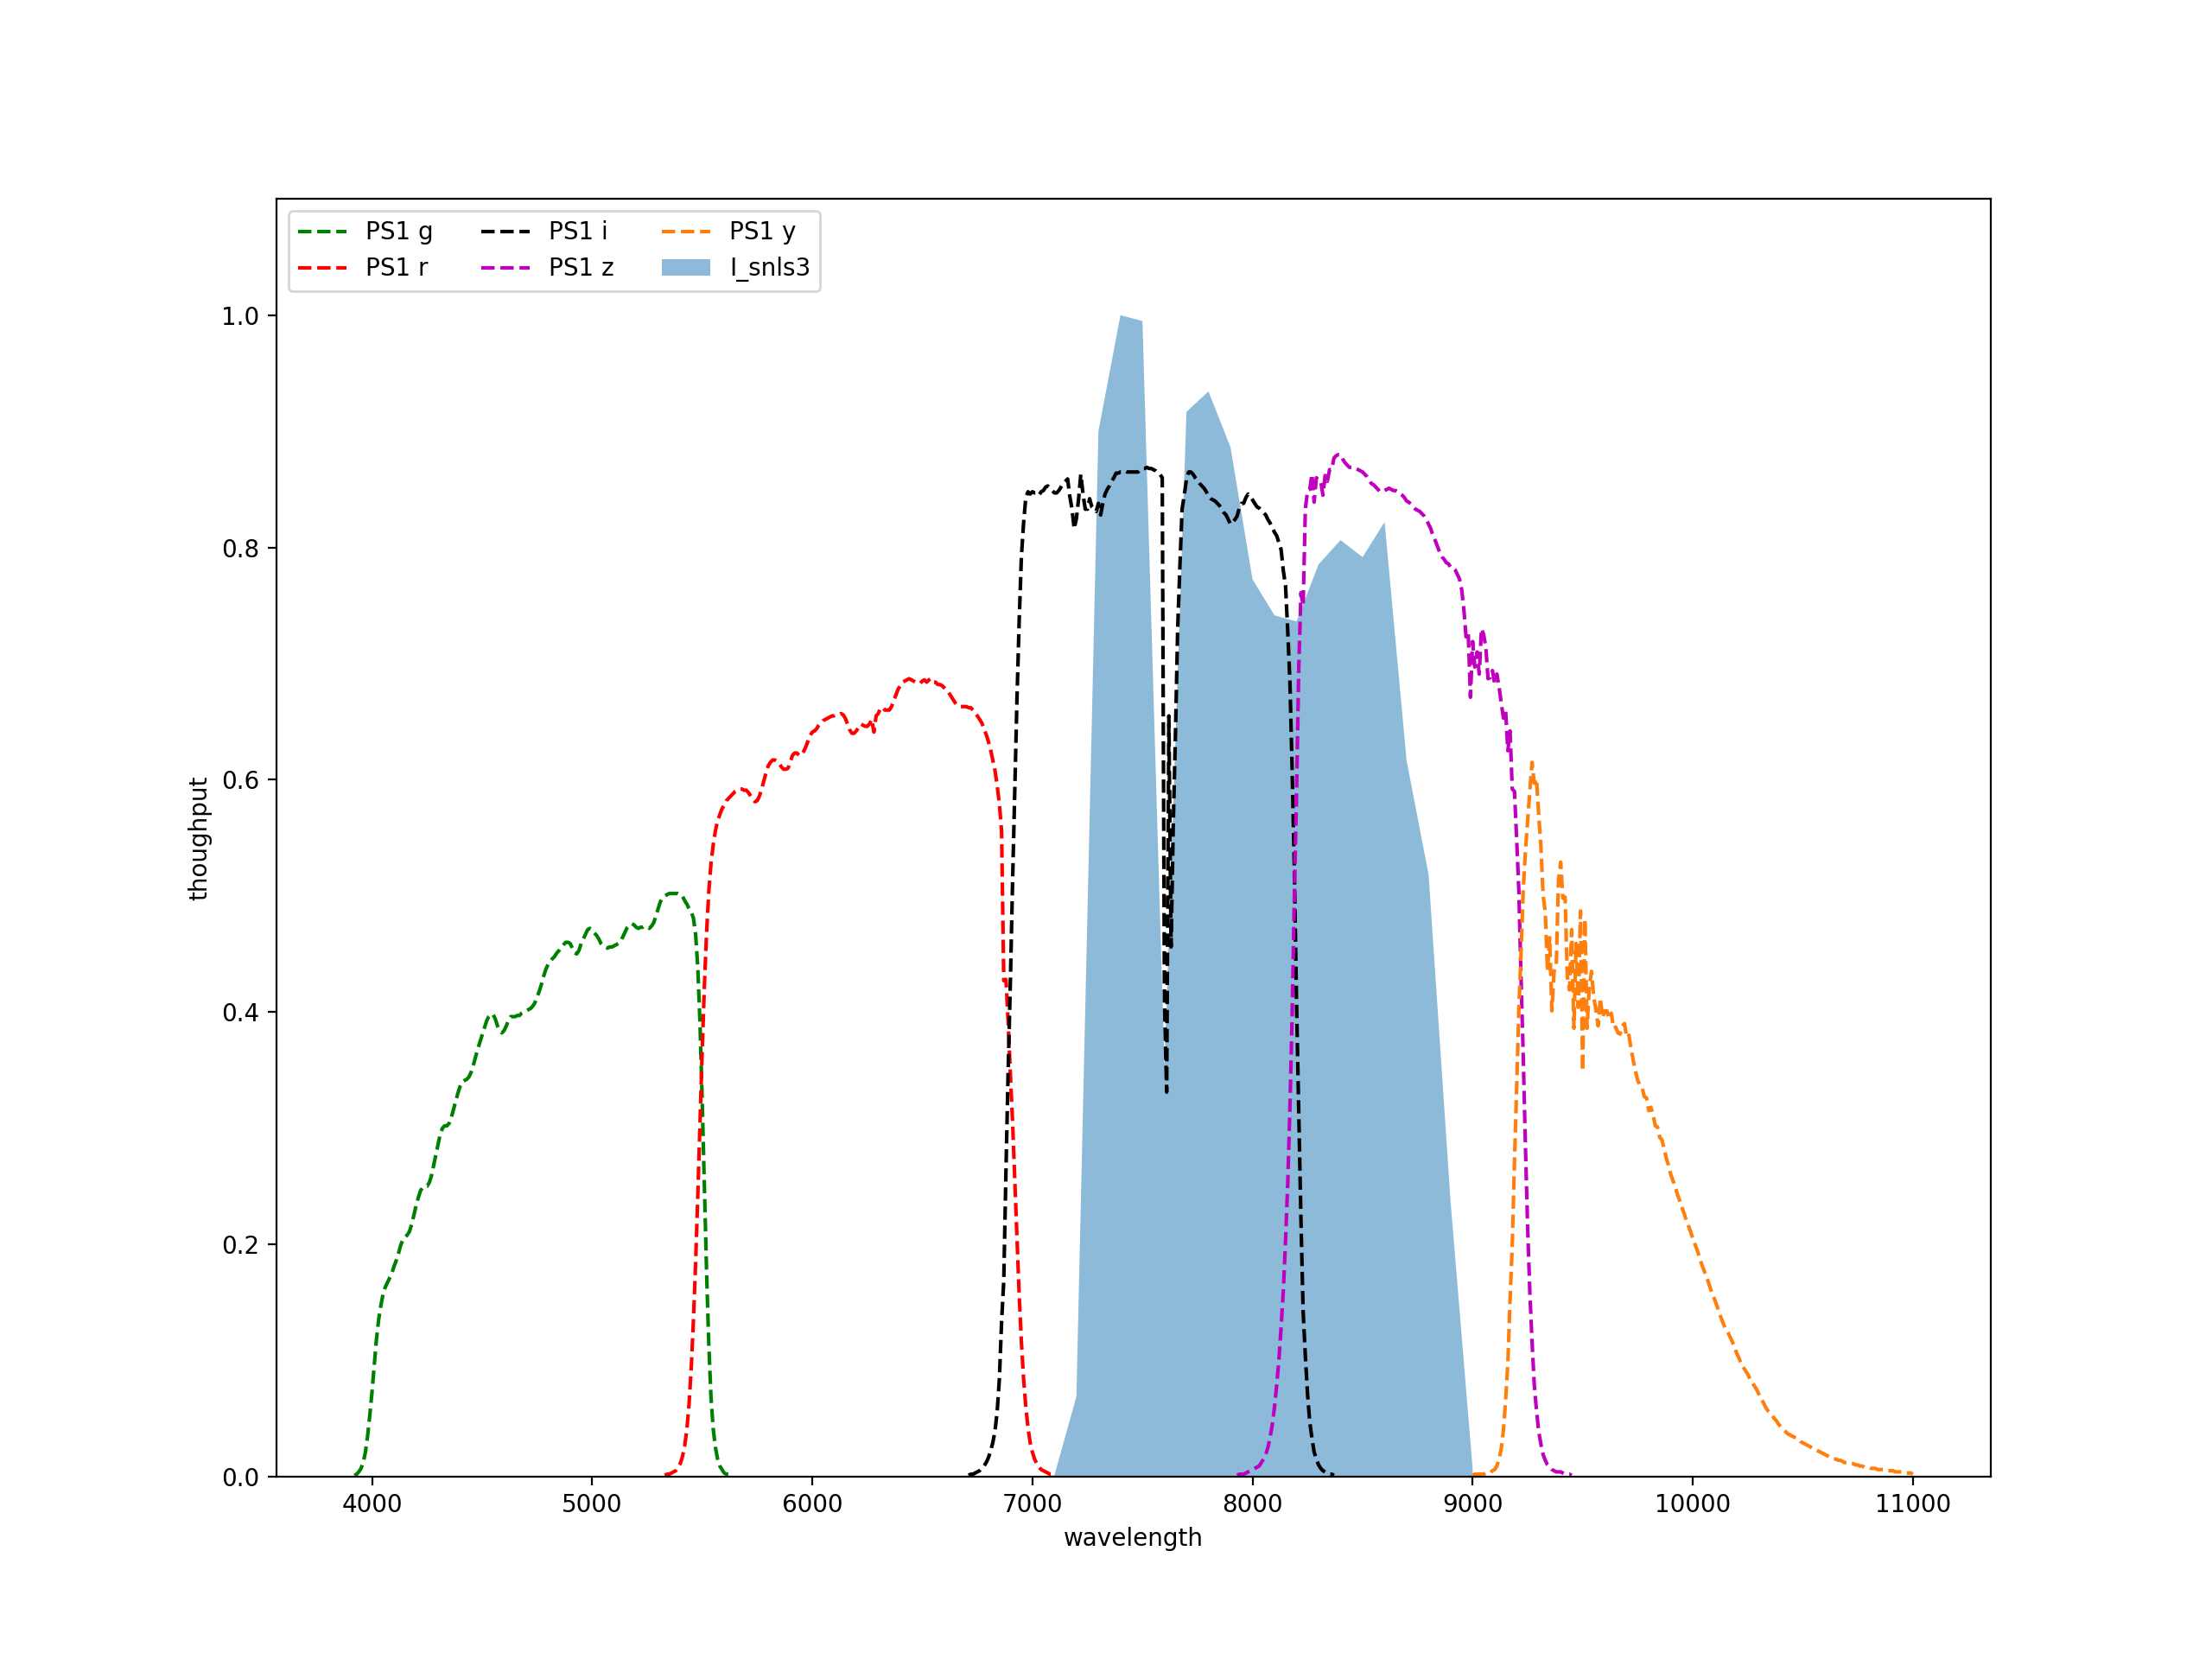

<IPython.core.display.Javascript object>


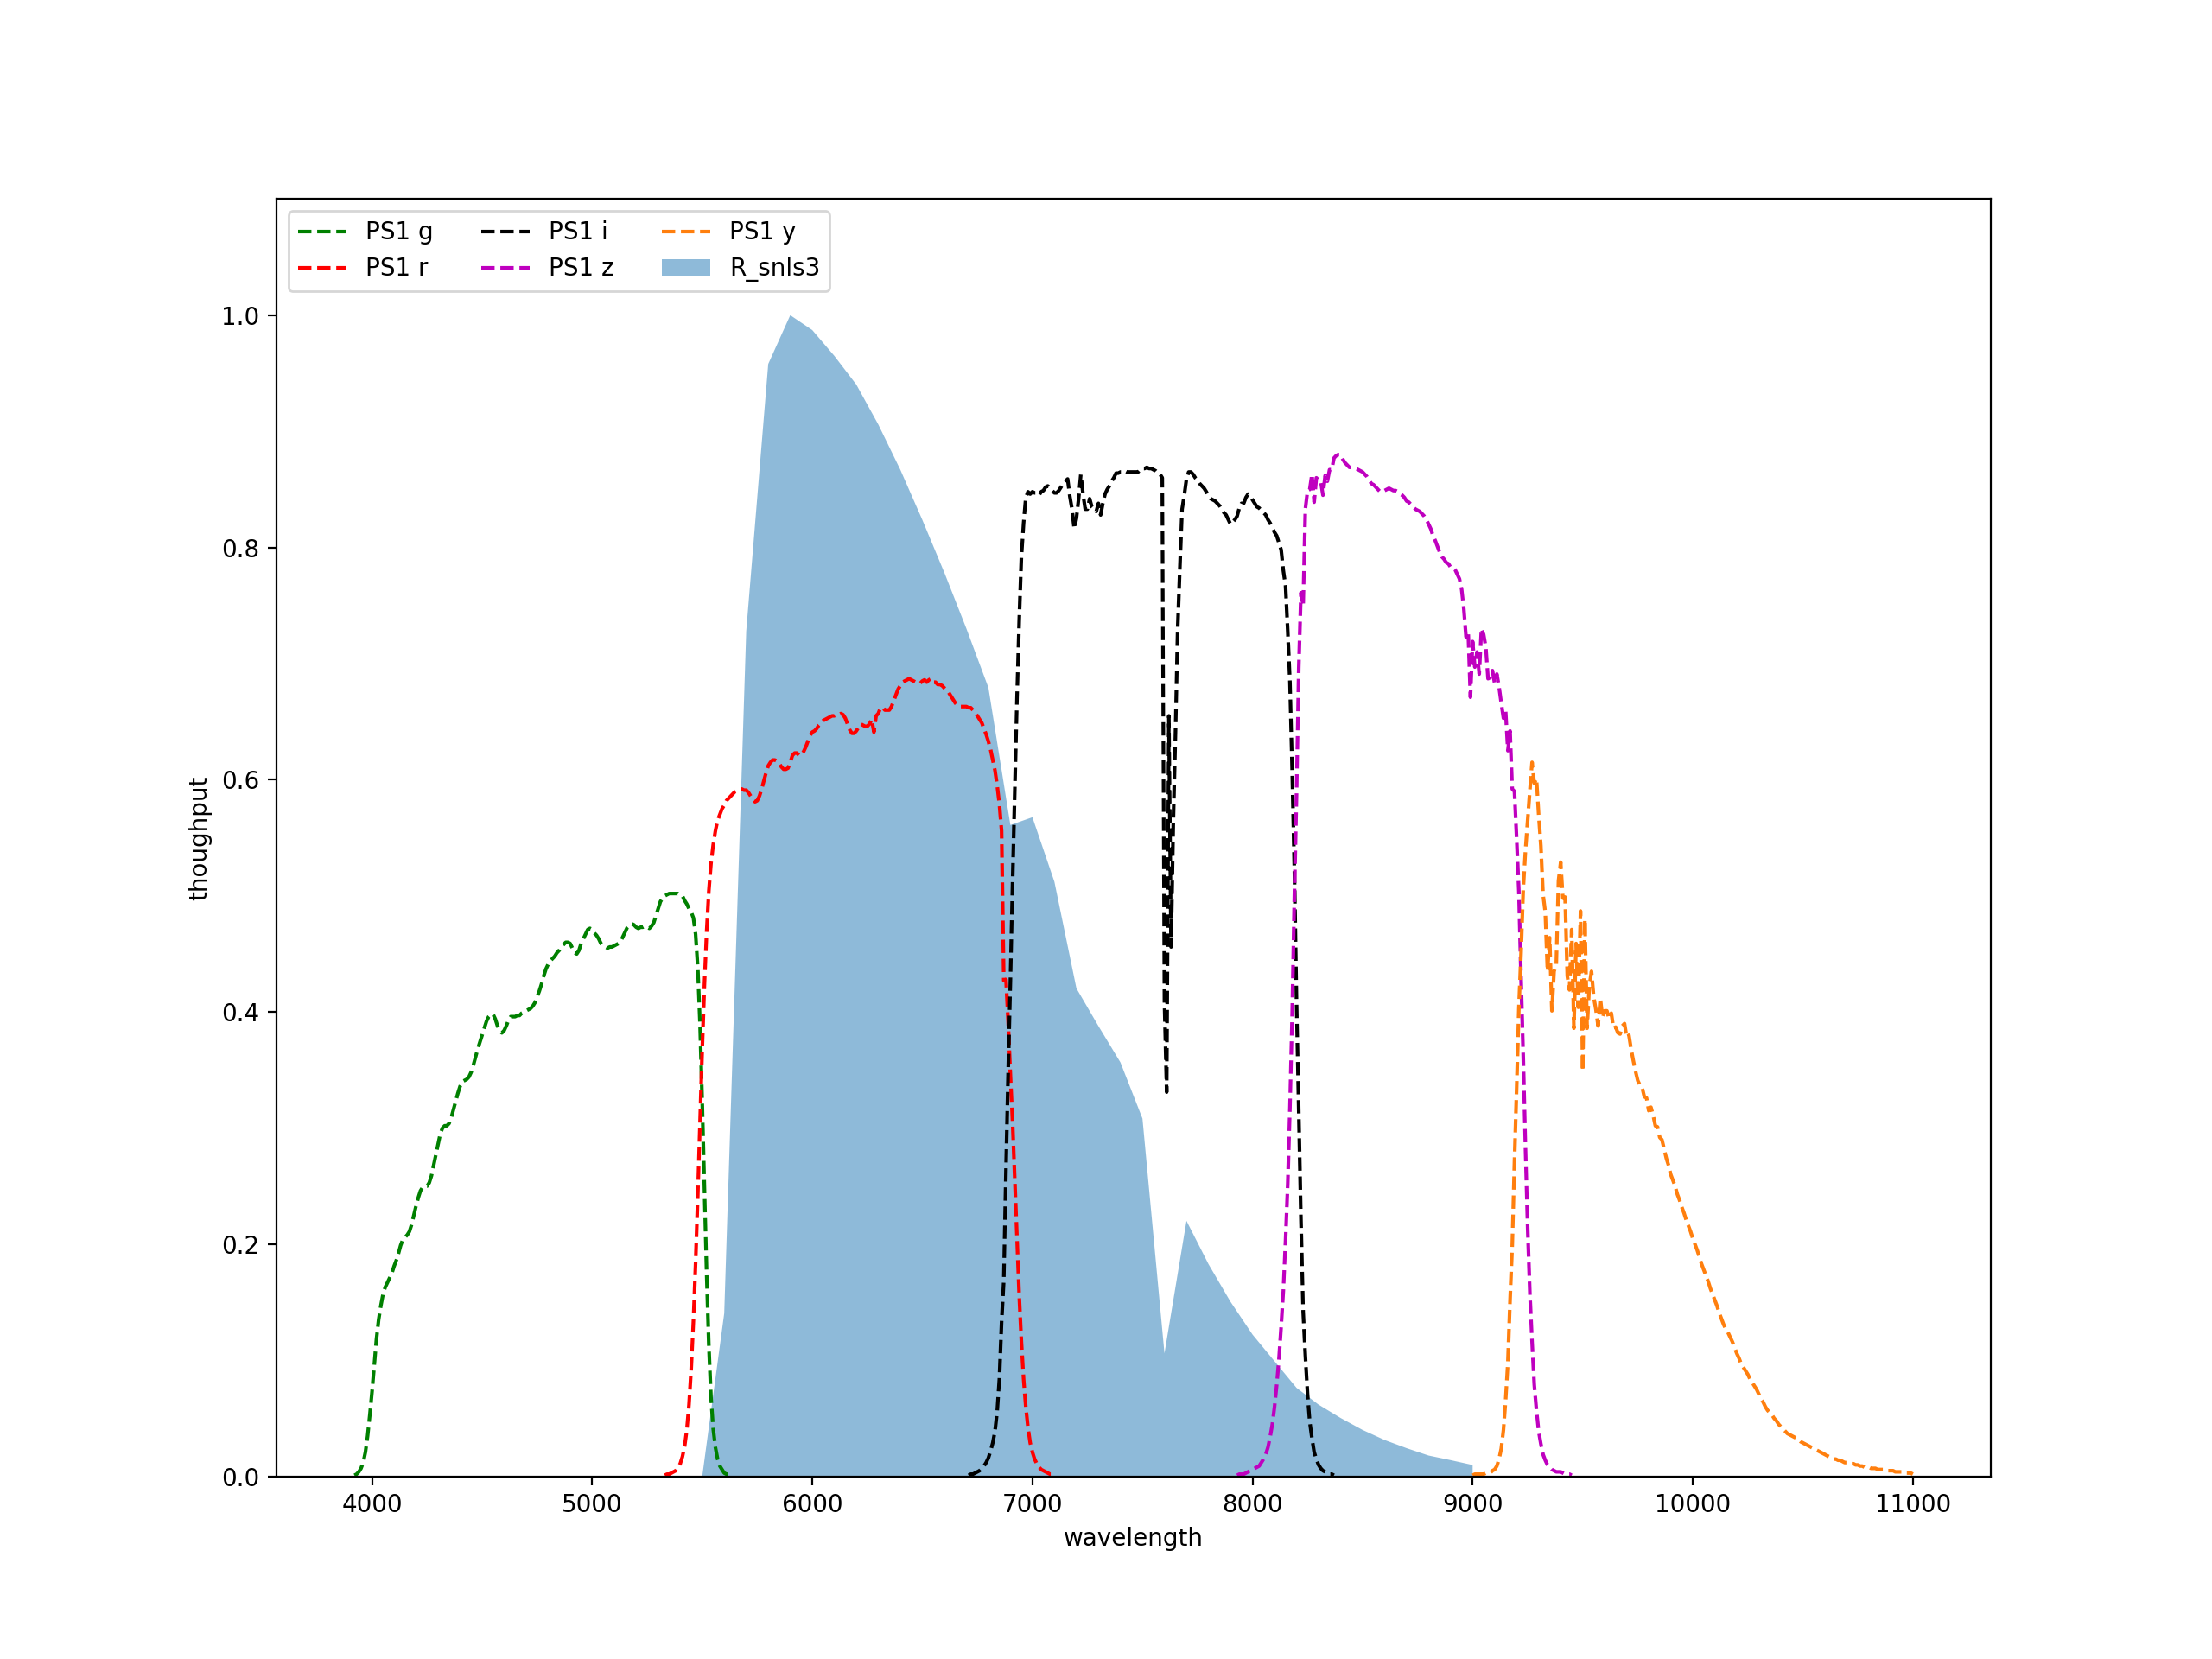

<IPython.core.display.Javascript object>


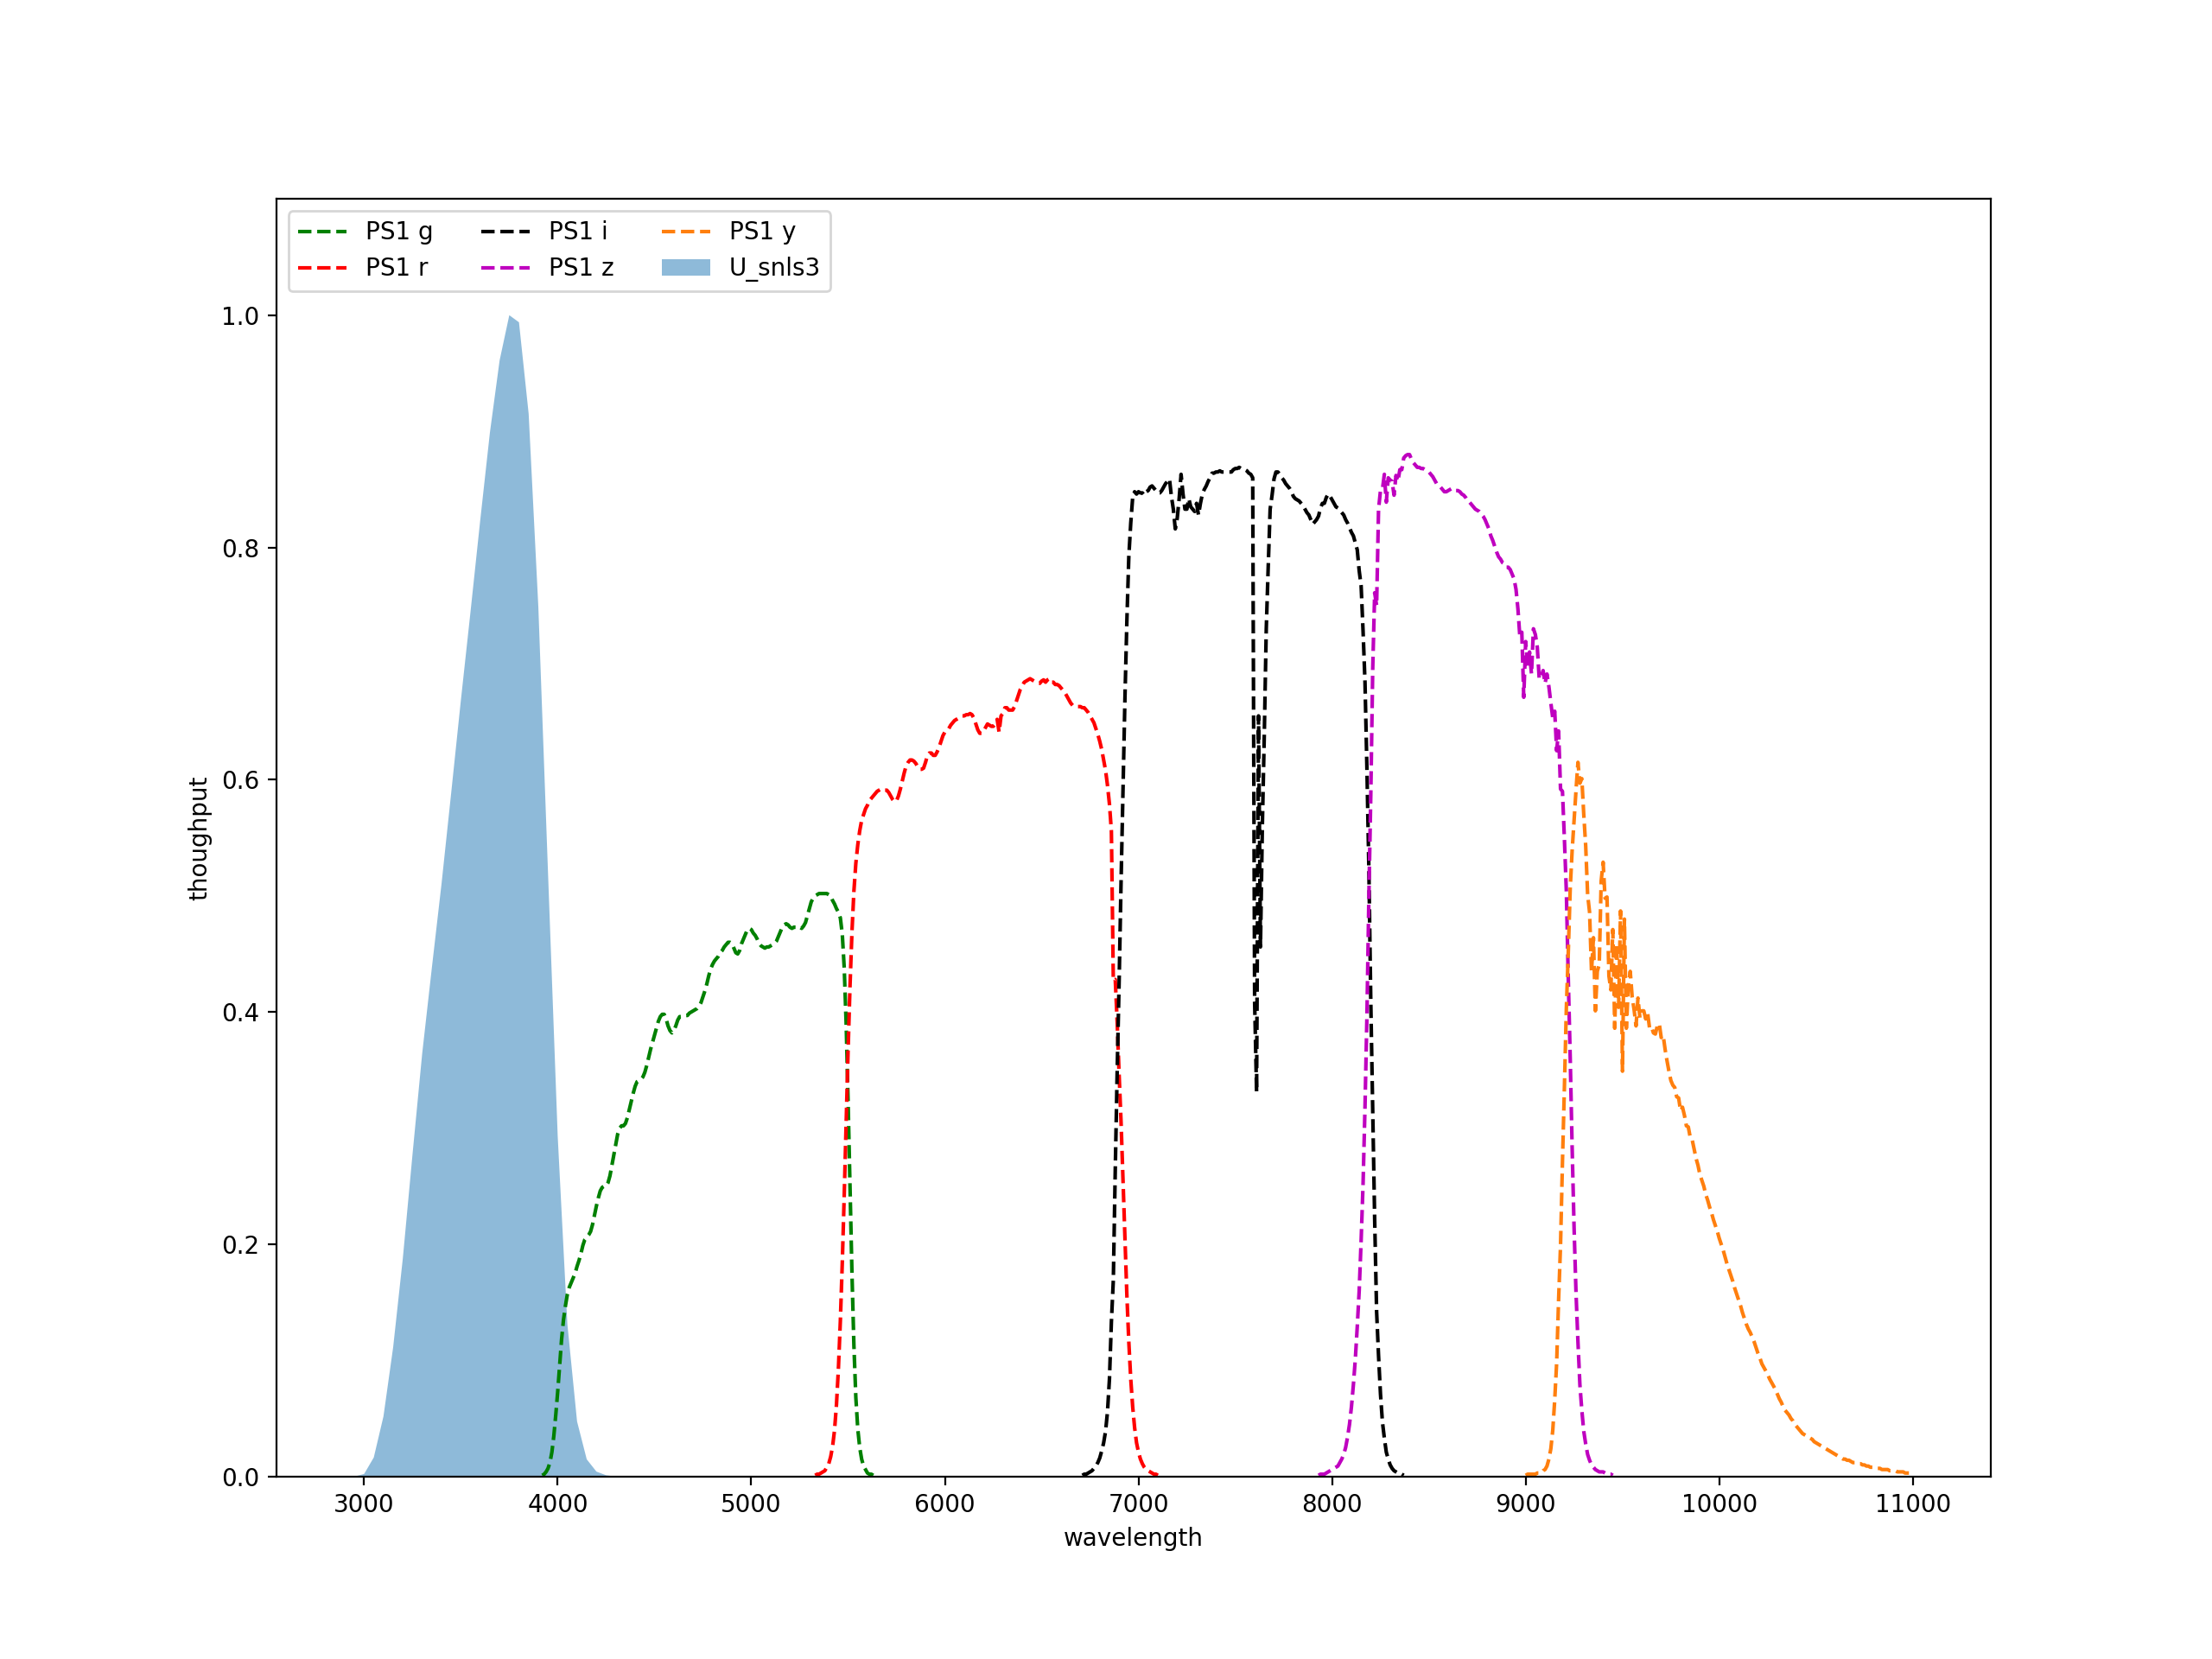

<IPython.core.display.Javascript object>


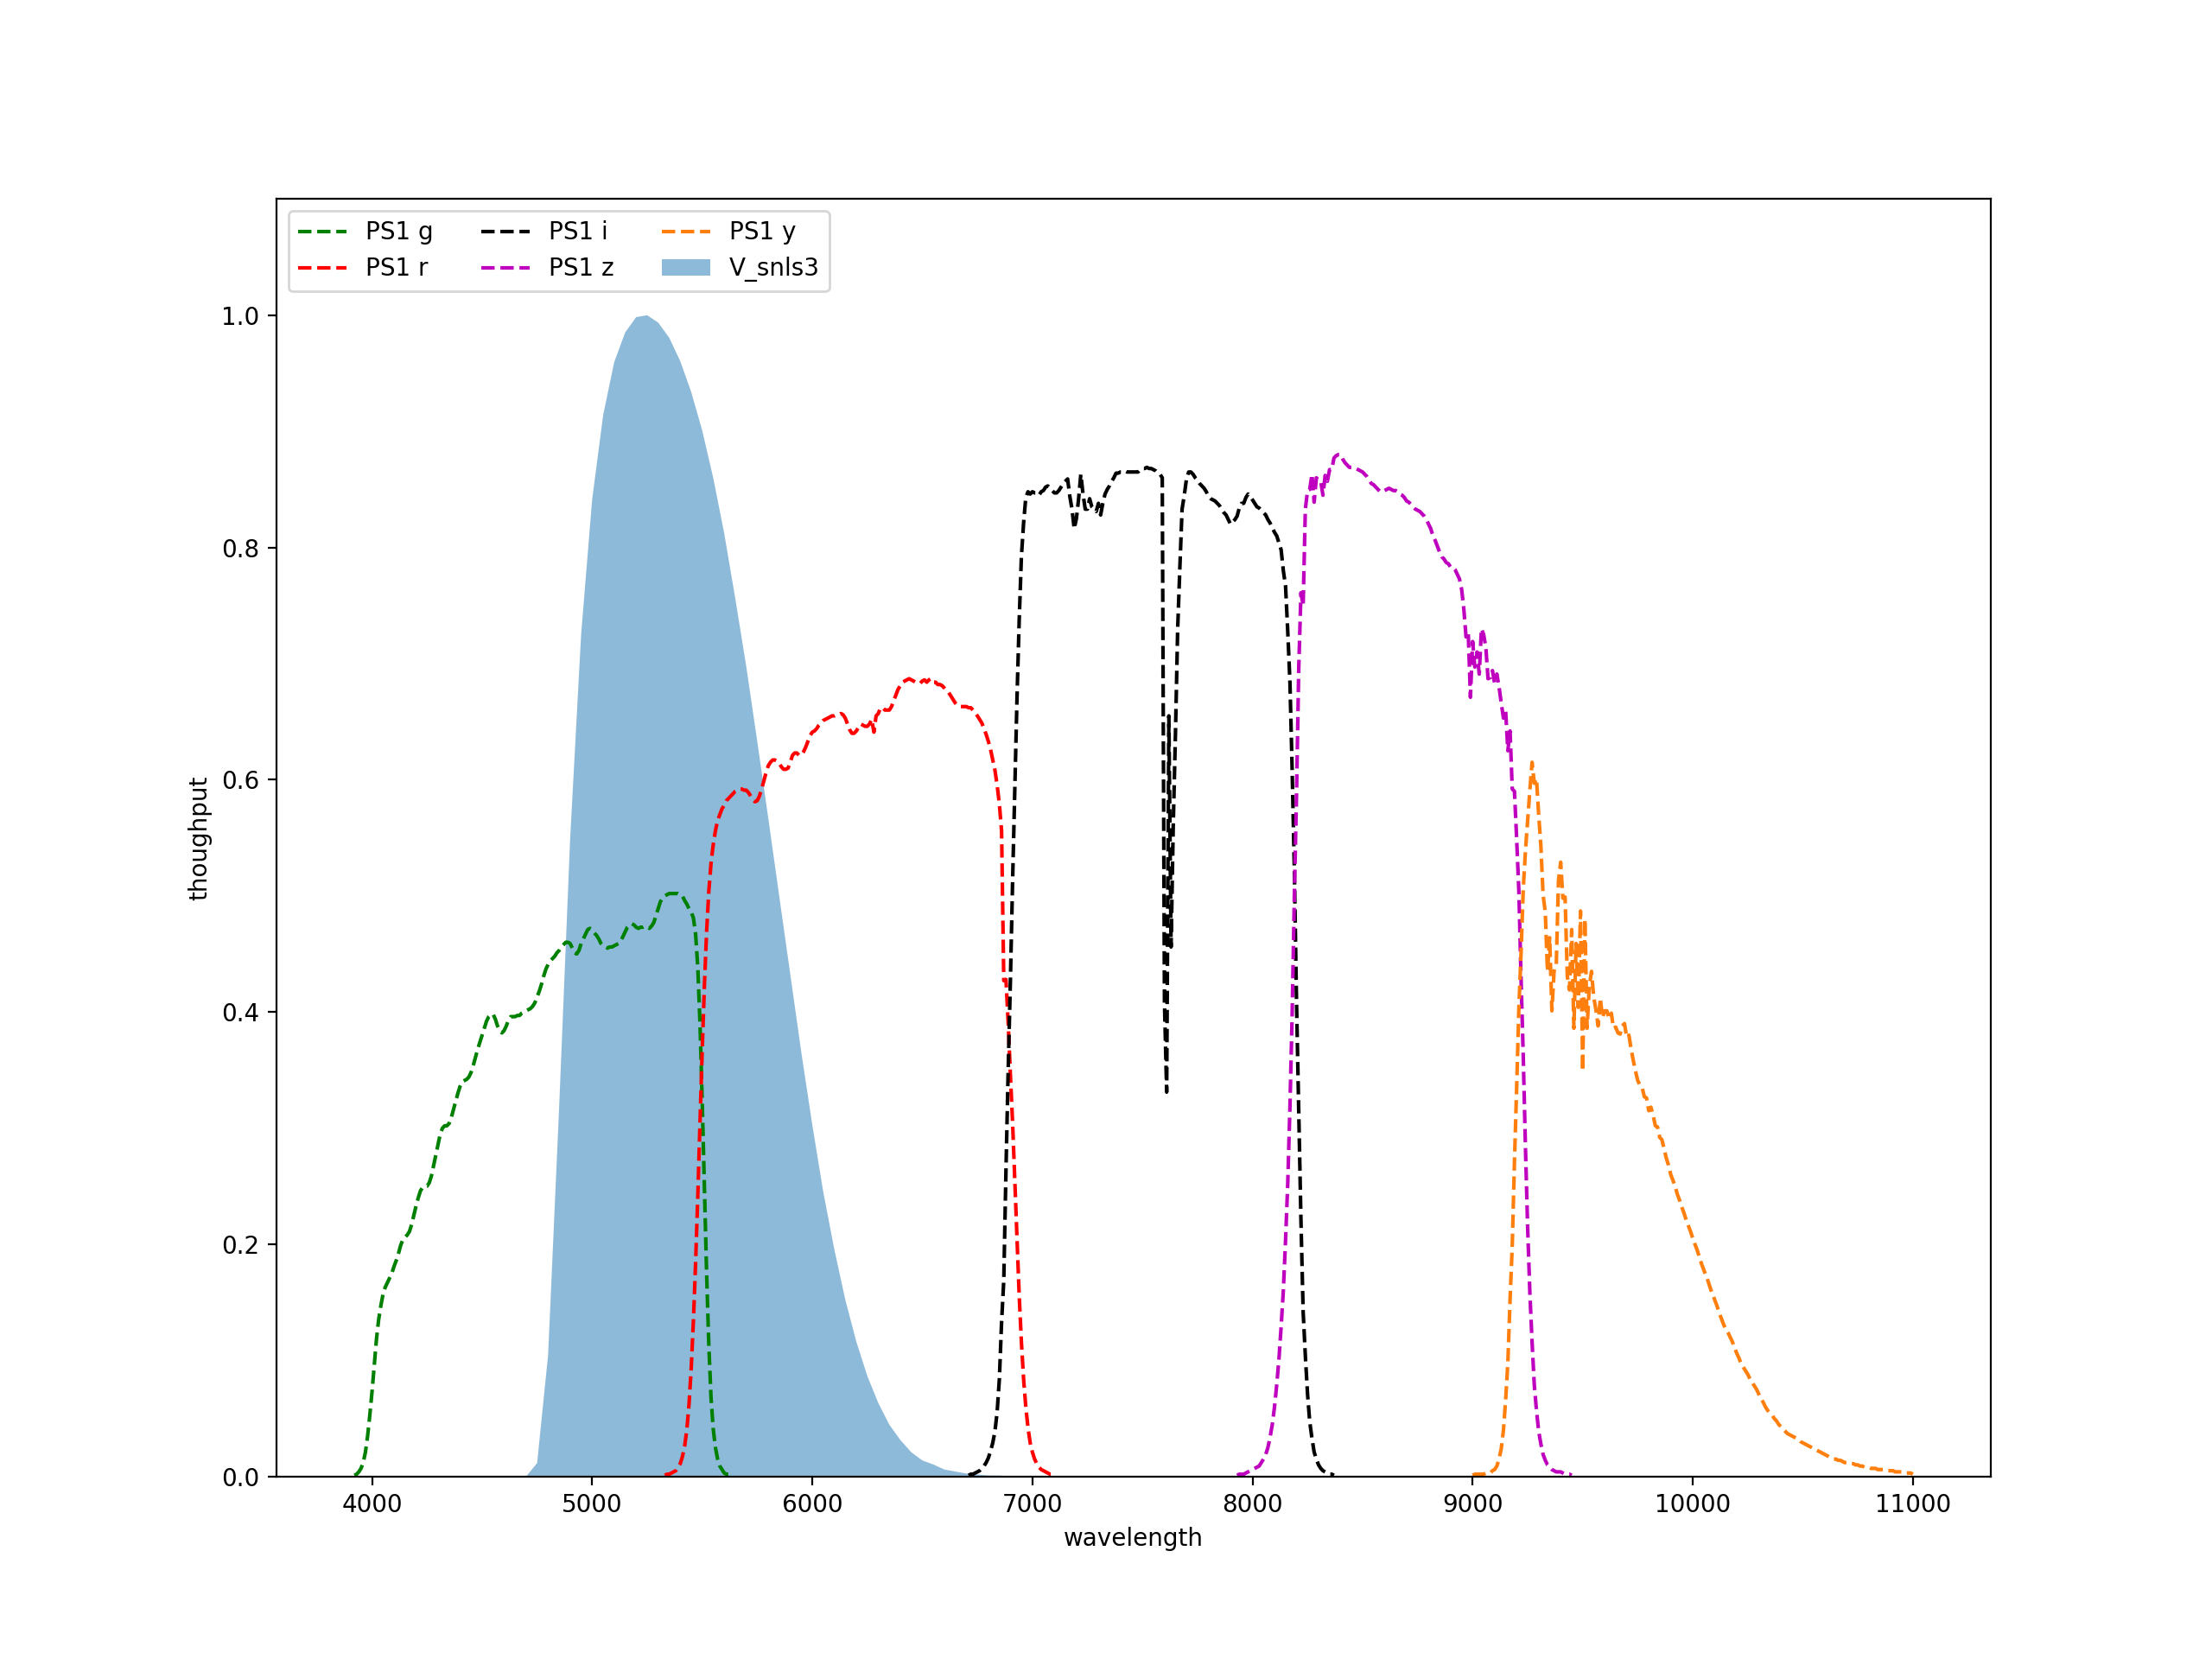

In [15]:
keys = list(pbs.keys())
for key in keys:
    plt.figure()
    plt.plot(ps1['ps1g'][0].wave,ps1['ps1g'][0].throughput,'g--',label='PS1 g')
    plt.plot(ps1['ps1r'][0].wave,ps1['ps1r'][0].throughput,'r--',label='PS1 r')
    plt.plot(ps1['ps1i'][0].wave,ps1['ps1i'][0].throughput,'k--',label='PS1 i')
    plt.plot(ps1['ps1z'][0].wave,ps1['ps1z'][0].throughput,'m--',label='PS1 z')
    plt.plot(ps1['ps1y'][0].wave,ps1['ps1y'][0].throughput,'C1--',label='PS1 y')
    #plt.plot(pbs[key][0].wave,pbs[key][0].throughput,label=key)
    plt.fill_between(pbs[key][0].wave,pbs[key][0].throughput,label=key,alpha =0.5)
    plt.legend(loc=2,ncol=3)
    plt.ylabel('thoughput')
    plt.xlabel('wavelength')
    plt.ylim(0,1.1)
    plt.savefig('figs/filter_overlap/keplercam/'+key+'.pdf')

In [24]:
len(ps1['ps1g'][0].wave)


172

In [25]:
len(ps1['ps1r'][0].wave)

178

# old calspec

In [17]:
path = '/Users/rridden/Documents/work/data/calspec/'
current = glob(path+'*.dat')
current = np.array(current)
files = np.array(glob(path+'*.dat'))

# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

cur = Specs(files)
cur = Spec_mags(cur,pbs)

names = []
for file in files:
    #a = fits.open(file.split('.dat')[0]+'.fits')[0].header['TARGETID']
    a = file.split('.dat')[0].split('/')[-1]
    names += [a]
names = np.array(names)

m = deepcopy(cur)
m['name'] = names
np.save('caspec_mags.npy',m)

/Users/rridden/Documents/work/data/calspec/hs2027_stis_005.dat
Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/bd_75d325_stis_005.dat
/Users/rridden/Documents/work/data/calspec/sdss132811_stis_003.dat
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/hz43b_stis_005.dat
/Users/rridden/Documents/work/data/calspec/hd38949_stis_005.dat
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/bd21d0607_stis_005.dat
/Users/rridden/Documents/work/data/calspec/hd031128_stis_005.dat
Warning, 1 of 6256 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/ngc6681_4_stis_001.dat
Warning, 26 of 2771 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/agk_81d266_stisnic_007.dat
/Users/rridden

Warning, 57 of 7167 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/bd_17d4708_stisnic_007.dat
/Users/rridden/Documents/work/data/calspec/hd93521_stis_006.dat
/Users/rridden/Documents/work/data/calspec/kf06t2_stiswfcnic_002.dat
Warning, 12 of 4801 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/hd60753_stis_004.dat
/Users/rridden/Documents/work/data/calspec/hz4_stis_007.dat
/Users/rridden/Documents/work/data/calspec/snap2_stiswfcnic_002.dat
Warning, 5 of 4761 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/hd101452_stis_002.dat
/Users/rridden/Documents/work/data/calspec/wd1327_083_stiswfc_003.dat
/Users/rridden/Documents/work/data/calspec/hd2811_stis_002.dat
Warning, 33 of 7206 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/calspec/wd1657_343_stiswfcnic_003.dat
/Users/rridden/

In [19]:
np.save('caspec_mags.npy',m)

In [73]:
cur

{'/Users/rridden/Documents/work/data/current_calspec/hs2027_stis_005.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f8673912340>,
 '/Users/rridden/Documents/work/data/current_calspec/bd_75d325_stis_005.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f85e2b3fdf0>,
 '/Users/rridden/Documents/work/data/current_calspec/sdss132811_stis_003.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f86739123d0>,
 '/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f85e2b25a00>,
 '/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f85e2fd43d0>,
 '/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f8655374460>,
 '/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f8673912250>,
 '/Users/rridden/Documents/work/data/curr

# simplify formats
for file in files:
    hdu = fits.open(file)
    spec = hdu[1].data
    s = np.array([spec.WAVELENGTH,spec.FLUX]).T
    s = pd.DataFrame(s,columns=['wave','flux'])
    s.to_csv(file.split('.')[0]+'.dat',index = False)

In [3]:
# select only the stis models, since those are the most well callibrated sources
ind = []
for i in range(len(files)):
    if 'stis' in files[i]:
        ind += [i]
ind = np.array(ind)
files = files[ind]

In [4]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("TESS/tess.")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [5]:
pbs

OrderedDict([('Kep',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f9948411640>,
               -21.405741755339733)),
             ('tess',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f9958f15fd0>,
               -21.8904558292275)),
             ('ps1g',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f9900488580>,
               -20.836195000114955)),
             ('ps1r',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f99197de550>,
               -21.370261319386927)),
             ('ps1i',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f9958f5dd00>,
               -21.793287528964058)),
             ('ps1z',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f9958f15cd0>,
               -22.09903034378283)),
             ('ps1y',
              (<pysynphot.spectrum.ArraySpectralElement at 0x7f9958f5dcd0>,
               -22.325516493196154))])

In [13]:
wd

'/Users/rridden/Documents/work/data/current_calspec/snap1_stisnic_007.dat'

/Users/rridden/Documents/work/data/current_calspec/hs2027_stis_005.dat
Warning, 5 of 3667 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd_75d325_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/sdss132811_stis_003.dat
Warning, 40 of 3660 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hz43b_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/hd38949_stis_005.dat
Warning, 5 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/bd21d0607_stis_005.dat
/Users/rridden/Documents/work/data/current_calspec/1805292_stisnic_005.dat
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/ngc6681_4_stis_001.dat
Warning, 26 of 2771 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Do

/Users/rridden/Documents/work/data/current_calspec/1808347_stiswfc_002.dat
Warning, 94 of 6875 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd55677_stis_002.dat
Warning, 12 of 7207 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/109vir_stis_002.dat
/Users/rridden/Documents/work/data/current_calspec/ngc6681_7_stis_001.dat
Warning, 919 of 2788 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd106252_stis_005.dat
Warning, 29 of 6262 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd37725_stiswfc_002.dat
Warning, 57 of 7167 bins contained negative fluxes; they have been set to zero.
/Users/rridden/Documents/work/data/current_calspec/hd93521_stis_006.dat
/Users/rridden/Documents/work/data/current_calspec/kf06t2_stiswfcnic_002.dat
Warning, 1

In [29]:
wds = glob('source_synphot/sources/wd/sdssj010322.dat')

In [30]:
wds

['source_synphot/sources/wd/sdssj010322.dat']

In [31]:
wd = Specs(wds)

source_synphot/sources/wd/sdssj010322.dat
nmatch 0


In [32]:
wd

{'source_synphot/sources/wd/sdssj010322.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98edab7490>}

In [63]:
model_sed = source_synphot.source.pre_process_source('test.dat',np.nan,'ps1g',0,Renorm=False)

In [19]:
pickle

{'/Users/rridden/Documents/work/data/current_calspec/snap1_stisnic_007.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f98e855ed60>,
 '/Users/rridden/Documents/work/data/current_calspec/g191b2b_stiswfcnic_002.dat': <pysynphot.spectrum.ArraySourceSpectrum at 0x7f9958f5d580>}

In [24]:
f = source_synphot.passband.synflux(pickle['/Users/rridden/Documents/work/data/current_calspec/snap1_stisnic_007.dat'],
                                pbs['ps1g'][0])


In [25]:
m = -2.5*np.log10(f) + pbs['ps1g'][1]

In [26]:
m

15.480743938254783

In [33]:
wdmodel = Spec_mags(wd,pbs,0)

lego
red  0.0


In [34]:
wdmodel

{'g': array([19.11639664]),
 'r': array([19.56338718]),
 'i': array([19.9327442]),
 'z': array([20.20857029]),
 'y': array([20.41189223]),
 'kep': array([19.49322306]),
 'tess': array([19.94822208])}

In [61]:
model = Spec_mags(pickle,pbs,3.1)

lego


In [56]:
a, b = model 

In [57]:
c.data

array([1.55418408e-14, 1.51663199e-14, 1.38712331e-14, ...,
       5.45523425e-17, 1.42345971e-16, 1.02975297e-16])

In [58]:
c = apply(fitzpatrick99(a.wave.astype('double'),.5,3.1),a.flux)

<IPython.core.display.Javascript object>


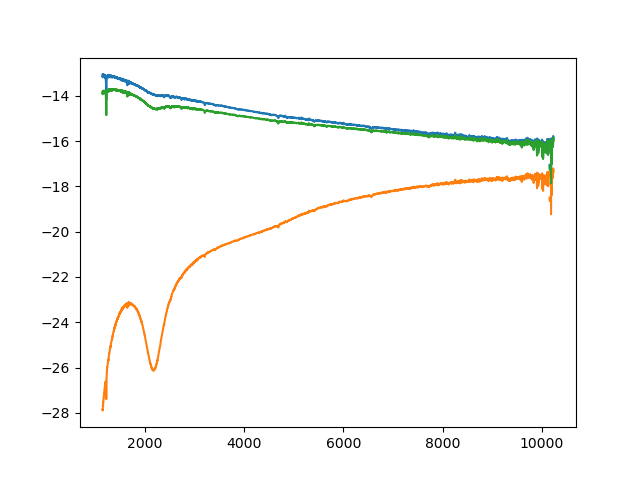

In [59]:
plt.figure()
plt.plot(a.wave,np.log10(a.flux))
plt.plot(b.wave,np.log10(b.flux))
plt.plot(b.wave,np.log10(c.data))

In [65]:
m

{'g': array([ 27.58718912,  20.44972476,  27.99360646,  24.67255246,
         18.86229662,  20.27543743,  23.27719316,  26.89322544,
         15.79291952,  22.82637102,  27.69690332,  19.18914503,
         27.56749272,  16.56597508,  20.32743128,  26.83408454,
         26.87006683,  21.32361619,  19.44156928,  22.56871696,
         23.89776567,  27.63643313,  26.63170639,  20.05677278,
         19.26577818,  23.50478857,  12.74793463,  17.84915021,
         23.82289585,  15.22191202,  20.75988316,  15.29836536,
         26.72074866,  24.26281678,  23.48156801,  16.06013082,
         25.59503804,  19.81028952,  22.81818882,  27.99091396,
         25.64479277,  23.09245962,  17.60097356,  16.77018338,
         24.4541998 ,  18.71076978,  24.56693375,  20.64718244,
         26.67092039,  25.85837857,  27.03964045,  20.18597308,
         19.78563286,  23.9471388 ,  22.07571442,  20.00457555,
         10.97891068,  20.76639332,  20.70924761,  20.40749814,
        -15.65472995,  17.47026894,

In [66]:
np.save('caspec_mags_av3p1.npy',m)

In [15]:
name

[['bd_28d4211_fos_003.dat'],
 ['hs2027_stis_005.dat'],
 ['kf01t5_nic_004.dat'],
 ['hd209458_mod_003.dat'],
 ['bd_75d325_stis_005.dat'],
 ['hd142331_mod_002.dat'],
 ['lds749b_mod_006.dat'],
 ['1808347_mod_004.dat'],
 ['mucol_mod_003.dat'],
 ['sdss132811_stis_003.dat'],
 ['bd_28d4211_005.dat'],
 ['hz43b_stis_005.dat'],
 ['hd38949_stis_005.dat'],
 ['bd21d0607_stis_005.dat'],
 ['ngc7293_005.dat'],
 ['grw_70d5824_005.dat'],
 ['gd50_004.dat'],
 ['1805292_stisnic_005.dat'],
 ['ngc6681_4_stis_001.dat'],
 ['1802271_mod_004.dat'],
 ['10lac_stis_005.dat'],
 ['agk_81d266_stisnic_007.dat'],
 ['ngc6681_3_stis_001.dat'],
 ['kf08t3_mod_003.dat'],
 ['hd111980_mod_002.dat'],
 ['hd37725_mod_004.dat'],
 ['wd0320_539_mod_001.dat'],
 ['hd185975_stis_005.dat'],
 ['sirius_mod_004.dat'],
 ['1743045_mod_003.dat'],
 ['hz21_005.dat'],
 ['c26202_stiswfcnic_002.dat'],
 ['18sco_stis_002.dat'],
 ['bd_75d325_005.dat'],
 ['hd115169_stis_002.dat'],
 ['hz43_mod_010.dat'],
 ['ngc6681_5_stis_001.dat'],
 ['hd128998_mod_002.

In [16]:
model

{'g': array([ 10.25057222,  16.44883333,  13.92692862,   7.78769937,
          9.27868075,   8.96618485,  14.56844385,  12.07038878,
          4.90281293,  16.98461044,  10.24688193,  14.52746569,
          7.96274815,   9.34486059,  13.27622232,  12.61383871,
         13.83675166,  12.24258723,  15.86286601,  11.917862  ,
          4.66558621,  11.65574582,  16.65124194,  13.63507971,
          8.53825989,   8.29809598,  14.71838844,   8.32061136,
         -1.56035906,  13.55052836,  14.44358812,  16.66583237,
          5.68467129,   9.29614164,   9.4470222 ,  12.67446436,
         15.83879266,   5.69679451,   6.43072342,  10.6501027 ,
          9.85245998,   8.05797179,   9.37298217,  11.57958585,
         14.56335303,  10.41571086,   8.53443744,  13.69397764,
         11.41418233,  12.87805221,   9.27612176,   6.76735509,
         16.61094521,  15.64540307,   9.23137395,   8.17450075,
          9.83034241,  12.47222546,   1.62236978,   6.83321183,
         12.66358264,   4.13243542,

In [11]:
np.save('current_caspec_mags.npy',model)

<IPython.core.display.Javascript object>


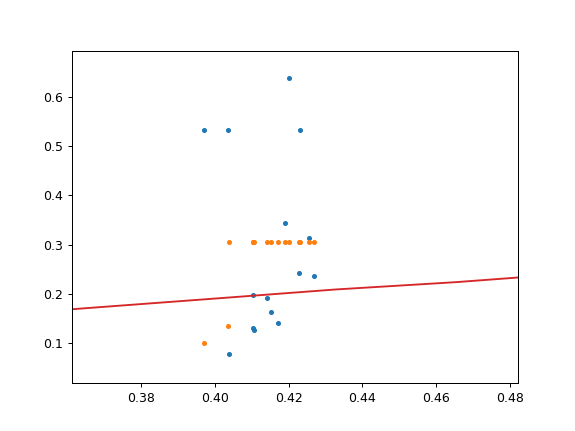

In [77]:
tonry = np.loadtxt('Tonry_splines.txt')
plt.figure()
plt.plot(model['r']-model['i'], model['g']-model['r'],'.')
plt.plot(model['r']-model['i'], model['i']-model['z'],'.')

plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')

In [114]:
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline

In [143]:
model['k']

array([ 14.21686579,   3.81060113,  12.08459247,   3.80905962,
        12.07408543,   0.13156085,   0.12273696,   0.12306352,
         9.84625735,   9.84811288,  10.05393934,   9.14615405,
         9.14882985,   9.63365089,   9.63630666,  10.15678299,
        10.15485045,   9.62408747,   9.62357073,   9.77694922,
         9.78077859,   9.39088998,   9.83008222,  10.6597207 ,
        10.66742424,  10.66843145,  10.95065699,  10.93984514,
         9.69683896,   9.6869003 ,   9.68935712,  16.41153943,
        16.40818272,   4.43121666,   4.42929801,   5.79076627,
         5.79234861,   1.96203512,   1.95083078,  11.97987694,
        11.98059455,  11.32222328,  11.30937163,  10.64919948,
        11.97419351,  11.92513747,  11.93199895,  11.92862112,
         9.28291323,  11.92910921,  12.89908675,  13.70314177,
        13.50341815,  13.50305718,  13.50310119,  13.18045926,
        13.18605772,  13.18557497,  12.37857467,  12.37665341,
        12.92439378,  12.91691832,  12.91756231,   8.73

In [6]:
ri = model['r']-model['i'] 
gr = model['g']-model['r']
iz = model['i']-model['z']
gk = model['g']-model['k']
rk = model['r']-model['k']
ki = model['k']-model['i']

In [8]:
ind = (ri<0.38) | (ri>1.25)
ind[(gr > 0.8)] = False
np.where(~ind)

(array([  2,  10,  17,  19,  31,  32,  37,  49,  50,  66,  68,  86, 137,
        144, 150, 163, 174, 193, 194, 195]),)

In [251]:
ri = model['r']-model['i'] 
gr = model['g']-model['r']
iz = model['i']-model['z']
gk = model['g']-model['k']
rk = model['r']-model['k']
ki = model['k']-model['i']
ind = (ri<0.38) | (ri>1.25)
ind[(gr > 1)] = False
ri = ri[ind]
gr = gr[ind]
iz = iz[ind]
gk = gk[ind]
rk = rk[ind]
ki = ki[ind]

eh = pd.DataFrame(data=np.array([ri,gr,iz,gk,rk,ki]).T,columns=['ri','gr','iz','gk','rk','ki'])
eh = eh.sort_values('gr',ignore_index=True)

In [15]:
f = []
for i in range(len(files)):
    f += [files[i].split('/')[-1].split('.')[0]]
f = np.array(f)

In [16]:
f[ind]

array(['bd_28d4211_fos_003', 'hs2027_stis_005', 'hd209458_mod_003',
       'bd_75d325_stis_005', 'hd142331_mod_002', 'lds749b_mod_006',
       'mucol_mod_003', 'sdss132811_stis_003', 'bd_28d4211_005',
       'hd38949_stis_005', 'bd21d0607_stis_005', 'ngc7293_005',
       'hd031128_stis_005', 'grw_70d5824_005', 'gd50_004',
       'agk_81d266_stisnic_007', 'kf08t3_mod_003', 'hd111980_mod_002',
       'hd37725_mod_004', 'wd0320_539_mod_001', 'hd185975_stis_005',
       'sirius_mod_004', 'hz21_005', 'c26202_stiswfcnic_002',
       'bd_75d325_005', 'hd115169_stis_002', 'hz43_mod_010',
       'hd165459_stisnic_005', 'hd128998_mod_002', 'hz43_fos_003',
       'bd_33d2642_004', 'hd37962_mod_003', 'hd180609_mod_003',
       'feige110_005', 'lds749b_005', 'bd29d2091_stis_005',
       'hd111980_stis_005', 'p177d_001', 'hz44_stis_006',
       'wd2341_322_stiswfc_003', 'bd_75d325_fos_003', 'hd93521_005',
       'hd009051_stis_005', 'hd116405_stis_005', 'bd26d2606_mod_002',
       'etauma_stis_005',

In [17]:
model2 = copy.deepcopy(model)
model2['r'] = model2['r'][ind]
model2['g'] = model2['g'][ind]
model2['i'] = model2['i'][ind]
model2['z'] = model2['z'][ind]
model2['k'] = model2['k'][ind]
model2['model'] = f
np.save('caspec_MS_mags.npy',model2)

In [18]:
test = np.load('caspec_MS_mags.npy',allow_pickle=True).item()

In [19]:
model.keys()

dict_keys(['g', 'r', 'i', 'z', 'k'])

In [20]:
test.keys()

dict_keys(['g', 'r', 'i', 'z', 'k', 'model'])

<IPython.core.display.Javascript object>


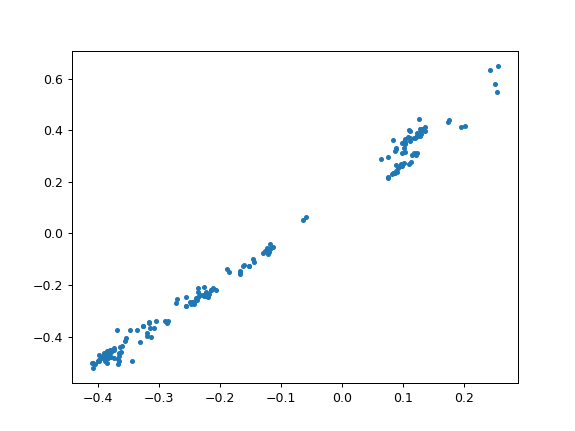

In [222]:
plt.figure()
plt.plot(model2['r']-model2['i'], model2['g']-model2['r'],'.')

<IPython.core.display.Javascript object>


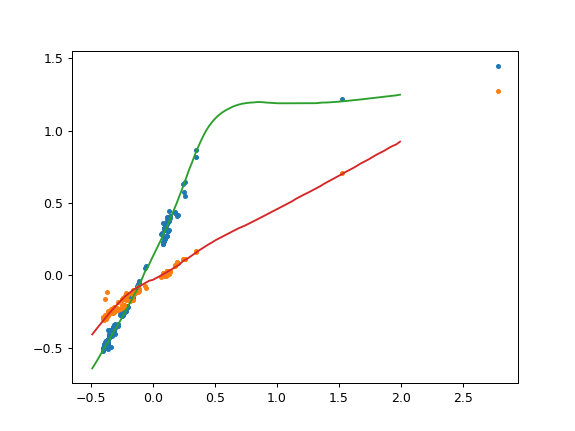

In [248]:
plt.figure()
plt.plot(ri, gr,'.')
plt.plot(ri, iz,'.')

plt.plot(tonry[:,0],tonry[:,1],'-')
plt.plot(tonry[:,0],tonry[:,2],'-')

In [148]:
gk.shape

(200,)

In [151]:
np.array([ri,gr,iz]).T.shape

(184, 3)

<IPython.core.display.Javascript object>


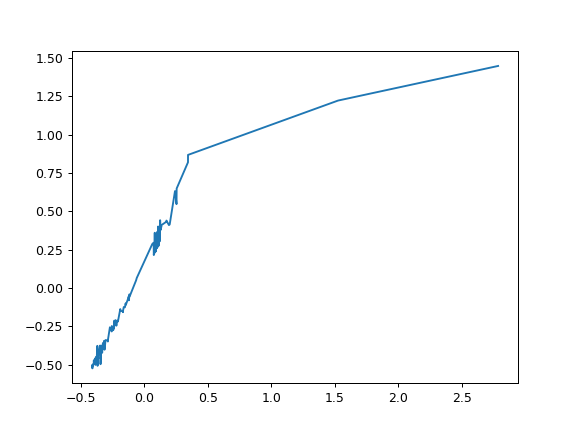

In [104]:
plt.figure()
plt.plot(eh.ri,eh.gr)

In [130]:
spl = UnivariateSpline(eh.ri[:-1], eh.gr[:-1])
x = np.arange(eh.ri.iloc[0],eh.ri.iloc[-2],0.01)

In [166]:
ind

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [131]:
#t = [-0.4, -0.2, 0, 0.2, 0.4, 0.6, 1, 2]
t = [-0.4, -0.2, 0, 0.2, 0.4, 2]
sp = LSQUnivariateSpline(eh.ri.values[:-1], eh.gr.values[:-1], t,k=1)

ValueError: Interior knots t must satisfy Schoenberg-Whitney conditions

<IPython.core.display.Javascript object>


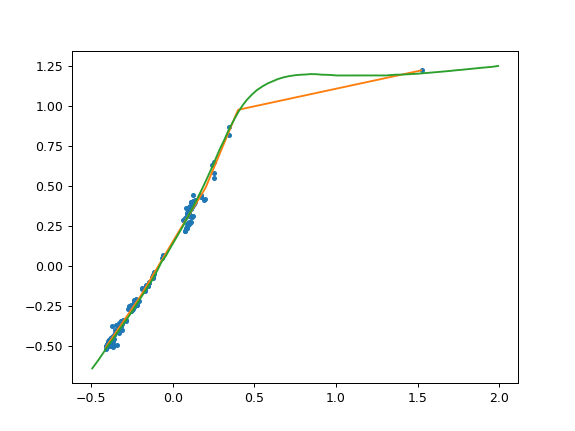

In [133]:
plt.figure()
plt.plot(eh.ri[:-1],eh.gr[:-1],'.')
plt.plot(x,sp(x))
#plt.plot(x,spl(x))
plt.plot(tonry[:,0],tonry[:,1],'-')

In [118]:
t = [-0.4, -0.2, 0, 0.2, 0.4, 2]

In [256]:
gks = UnivariateSpline(eh.gr, eh.gk)
rks = UnivariateSpline(eh.gr, eh.rk)
kis = UnivariateSpline(eh.gr, eh.ki)
x = np.arange(eh.gr.iloc[0],eh.gr.iloc[-1],0.01)

<IPython.core.display.Javascript object>


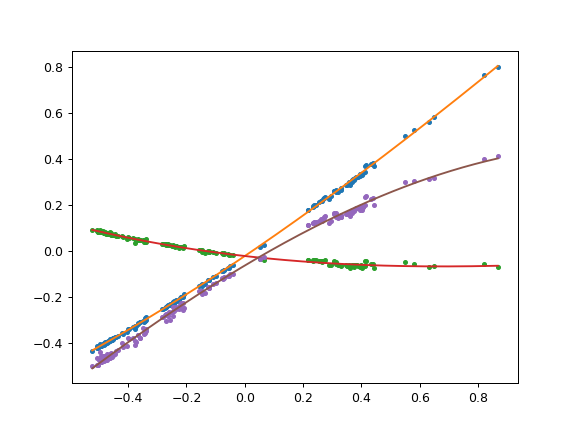

In [257]:
plt.figure()
plt.plot(eh.gr,eh.gk,'.')
plt.plot(x,gks(x))

plt.plot(eh.gr,eh.rk,'.')
plt.plot(x,rks(x))

plt.plot(eh.gr,eh.ki,'.')
plt.plot(x,kis(x))

In [137]:
np.where


In [237]:
test = model2['r']-model2['i']

In [239]:
b = test.argsort()

In [240]:
test2 = test[b]

In [241]:
test2.argsort()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

In [242]:
test2

array([-0.4089104 , -0.40789659, -0.40769239, -0.40444598, -0.40028913,
       -0.39959728, -0.39861435, -0.39786265, -0.39734008, -0.39719314,
       -0.39491314, -0.3944859 , -0.39098093, -0.39028573, -0.38980858,
       -0.38893963, -0.38774846, -0.38737635, -0.387204  , -0.38716233,
       -0.38670856, -0.38668916, -0.38488747, -0.38478002, -0.38476725,
       -0.38323341, -0.38299999, -0.38293914, -0.38224485, -0.38209857,
       -0.37946086, -0.37919482, -0.37884095, -0.37834584, -0.37810772,
       -0.37765151, -0.37754944, -0.37391598, -0.37329186, -0.37328557,
       -0.36908602, -0.36762629, -0.36757115, -0.3659239 , -0.36538713,
       -0.36530642, -0.36413684, -0.36191268, -0.36014541, -0.35513097,
       -0.35434385, -0.34714925, -0.34410998, -0.33618988, -0.33118596,
       -0.32590507, -0.32537288, -0.32013505, -0.31884866, -0.31667078,
       -0.31570829, -0.31401335, -0.31253792, -0.30773986, -0.30513254,
       -0.28922088, -0.28681652, -0.28580692, -0.27255067, -0.27